![pytorch logo](https://mohammadijoo.com/image/PyTorch-logo.png)

# Deep Learning Models


In this notebook, we will be using the following Deep Learning models using Pytorch

1. GRU
2. Bidirectional GRU
3. LSTM
4. Bidirectional LSTM
5. DistilBERT Classifier

For models 1-4, we will be using **Word Embeddings** and **Pre-trained Word Embeddings** (GloVe and FastText)

For model 5, we will be using a **Pre-Trained DistilBERT Classifier**

We will also conclude the project in this notebook.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import os
import io

import torch
import torch.nn as nn
import torch.optim as optim
import torchtext.vocab as vocab 
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from lime.lime_text import LimeTextExplainer

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,6)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### File Paths


Running this notebook requires a local copy of GloVe and FastText, they can be downloaded [here](https://nlp.stanford.edu/projects/glove/) and [here](https://fasttext.cc/docs/en/english-vectors.html). The versions used in this notebook are as follows: 

* GloVe: 6B tokens, 400K vocab, uncased, 300d


* FastText: 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).

Replace the paths accordingly.

In [6]:
destination_path = 'YOURPATH'
file = 'YOURPATH'
glove_directory = 'YOURPATH'
ft_directory = 'YOURPATH'
saved_model_path = '../models/distilbert'

### Import the respective Train, Validation and Test Datasets.

In [7]:
df_corpus = pd.read_csv('../data/reviews_clean.csv')
df_train = pd.read_csv('../data/train.csv')
df_val = pd.read_csv('../data/val.csv')
df_test = pd.read_csv('../data/test.csv')


sentences_train = df_train['text'].values
labels_train = df_train['class'].values

sentences_val = df_val['text'].values
labels_val = df_val['class'].values

sentences_test = df_test['text'].values
labels_test = df_test['class'].values

In [8]:
print(df_corpus.isnull().sum())

df_corpus.dropna(inplace=True, axis=0)
df_corpus.reset_index(inplace=True, drop=True)

category            0
rating              0
label               0
text                0
class               0
clean_text          1
text_word_length    0
dtype: int64


In [9]:
print(len(df_corpus))
print(len(sentences_train))
print(len(sentences_val))
print(len(sentences_test))

40390
22640
5661
12130


### Preprocessing for Deep Learning


We will be using a Pytorch Library called **torchtext** to build to preprocess our dataset, build our model vocabulary, split our data and set up our iterator to feed our data into the Deep Learning 
models.

In [7]:
# Uncomment to install spacy as we are using the spacy tokenizer 
# !pip install spacy       

In [8]:
# text preprocessing
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize= en_tokenizer, lower=True, include_lengths=True, batch_first=True)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset
training, valid, test = TabularDataset.splits(path=file, train='train.csv', validation='val.csv', test='test.csv',
                                           format='csv', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(training, batch_size=64, sort_key=lambda x: len(x.text), device=device,
                            sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=64, sort_key=lambda x: len(x.text), device=device,
                            sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=64, sort_key=lambda x: len(x.text), device=device,
                            sort=True, sort_within_batch=True)

# Vocabulary
text_field.build_vocab(training, min_freq=2)

### Out-of-Vocabulary Words for Pretrained Word Embeddings: GloVE, FastText and DistilBERT

We will be using the above **Pre-trained Word Embeddings** to represent words in our dataset. The pre-trained embeddings come with pre-loaded word vectors that capture meanings between words (thru prior training) and are represented in vector space such that semantic relationships between words are preserved.

However, there might be words in our dataset that the pre-trained embeddings did not see during their training. As seen from the code cells below, there are quite a number of Out-of-Vocabulary(OOV) words that could not be represented by the pre-trained embeddings. Both GloVe and FastText represent OOV words as zero vectors.

As these words are not represented in vector space, we can expect the performances of models using the GloVe and FastText embeddings to be sub-optimal.


There are no OOV words for DistilBERT as DistilBERT uses **WordPiece Tokenization**, it is a different tokenization method where OOV words are broken down further to sub-words, at the extreme, OOV words may be broken down and represented by word vectors of alphabets.

| Pre-Trained Embedding | Vocabulary Size | OOV Words |  |  |
|---|---|---|---|---|
| GloVe | 400,000 | 471 |  |  |
| FastText | 999,994 | 884 |  |  |
| DistilBERT | 30,552 | 0 |  |  |

#### GloVe

In [9]:
vocab_glove= []
with open(glove_directory,'rt', encoding='utf8') as fi:
    full_content = fi.read().strip().split('\n')
for i in tqdm(range(len(full_content)), leave=False):
    i_word = full_content[i].split(' ')[0]
    vocab_glove.append(i_word)

count = 0
vocab_text = text_field.vocab.itos[2:]
oov_glove = []
for word in vocab_text:
    if word not in vocab_glove:
        count +=1
        oov_glove.append(word)

print(f'The vocabulary size of the pre-trained GloVe embeddings consists of {len(vocab_glove)} words.')
print(f'There are {count} OOV words found in the pre-trained GloVe embeddings.')
print()
print(oov_glove[:10])

  0%|          | 0/400000 [00:00<?, ?it/s]

The vocabulary size of the pre-trained GloVe embeddings consists of 400000 words.
There are 471 OOV words found in the pre-trained GloVe embeddings.

['nbsp', 'cm_cr_arp_d_rvw_txt', 'href', 'utf', 'schlage', 'dimmable', 'plier', 'netgalley', 'hadn', 'tootlemania']


### FastText

In [10]:
vocab_ft = []
fin = io.open(ft_directory, 'r', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(int, fin.readline().split())
for line in tqdm(fin, leave=False):
    tokens = line.rstrip().split(' ')
    vocab_ft.append(tokens[0])

count = 0
oov_ft = []
for word in vocab_text:
    if word not in vocab_ft:
        count +=1
        oov_ft.append(word)

print(f'The vocabulary size of the pre-trained FastText embeddings consists of {len(vocab_ft)} words.')
print(f'There are {count} OOV words found in the pre-trained FastText embeddings.')
print()
print(oov_ft[:10])

0it [00:00, ?it/s]

The vocabulary size of the pre-trained FastText embeddings consists of 999994 words.
There are 884 OOV words found in the pre-trained FastText embeddings.

['cm_cr_arp_d_rvw_txt', 'utf', 'schlage', 'keurig', 'netgalley', 'dewalt', 'rosanna', 'kinsella', 'grisham', 'tootlemania']


### DistilBERT


100 is the token number for OOV words ('UNK' token). Presence of the 'UNK' token will indicate OOV words.

In [11]:
tqdm.pandas()

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
df_corpus['bert_tokens'] = df_corpus['clean_text'].progress_apply(lambda x: tokenizer.encode(x))

count = 0
for i in df_corpus['bert_tokens']:
    if i == 100:
        count+=1

print('The vocabulary size of DistilBERT consists of 30552 words.')
print(f'There are {count} OOV words in DistilBERT.')

  0%|          | 0/40390 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors


The vocabulary size of DistilBERT consists of 30552 words.
There are 0 OOV words in DistilBERT.


## Pytorch Model Classes

In [12]:
# GRU
class GRU(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(input_size=300,
                        hidden_size=hidden_dim,
                        num_layers=1,
                        batch_first=True,
                        bidirectional=False)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.gru(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        out_forward = output[:,-1,:]
        text_fea = self.drop(out_forward)
        text_fea = self.fc(text_fea)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [13]:
# Bidirectional GRU
class B_GRU(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(B_GRU, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(input_size=300,
                        hidden_size=hidden_dim,
                        num_layers=1,
                        batch_first=True,
                        bidirectional=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*hidden_dim, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.gru(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :hidden_dim]
        out_reverse = output[:, 0, hidden_dim:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)
        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [14]:
# LSTM
class LSTM(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(input_size=300,
                        hidden_size=hidden_dim,
                        num_layers=1,
                        batch_first=True,
                        bidirectional=False)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        out_forward = output[:,-1,:]
        text_fea = self.drop(out_forward)
        text_fea = self.fc(text_fea)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [15]:
# Bidirectional LSTM
class B_LSTM(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(B_LSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(input_size=300,
                        hidden_size=hidden_dim,
                        num_layers=1,
                        batch_first=True,
                        bidirectional=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*hidden_dim, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :hidden_dim]
        out_reverse = output[:, 0, hidden_dim:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)
        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

## Modelling

### Functions for LSTM & GRU Models

#### Seeding for Reproducibility

In [16]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#### Accuracy Calculation 

In [17]:
def binary_acc (y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    accuracy = (y_pred_tag == y_test).sum()/len(y_test)
    
    return accuracy

#### Save Checkpoint & Metrics

In [18]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'train_acc_list': train_acc_list,
                  'valid_acc_list': valid_acc_list,
                  'epoch_list': epoch_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['train_acc_list'], state_dict['valid_acc_list'], state_dict['epoch_list']


#### Training and Validation Loop

In [19]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter),
          file_path = destination_path,
          best_valid_loss = float('Inf')):
    
    # initialize running values & containers for metrics
    seed_everything()
    running_loss = 0.0
    valid_running_loss = 0.0
    running_acc = 0.0
    valid_running_acc = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    epoch_list = []
    
    # variables to enable early stopping
    max_loss = 100
    patience = 10
    trigger_times = 0

    # training loop
    for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, leave=False)
        for ((text, text_len),labels), _ in progress_bar: 
            model.train()
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)
            output = output.squeeze()
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = binary_acc(output, labels)
            
            # update running values
            running_loss += loss.item()
            running_acc += acc.item()
            global_step += 1
            
            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for ((text, text_len), labels), _ in valid_loader:
                        labels = labels.to(device)
                        text = text.to(device)
                        text_len = text_len.to(device)
                        output = model(text, text_len)
                        output = output.squeeze()

                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()
                        valid_running_acc += binary_acc(output, labels).item()
                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                average_train_acc = running_acc / eval_every
                average_valid_acc = valid_running_acc / len(valid_loader)
                
                # early stopping
                if average_valid_loss > max_loss:
                    trigger_times += 1
                    
                    if trigger_times >= patience:
                        print('\nEarly stopping!')
                        save_metrics(file_path + '../metrics.pt', train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)
                        save_checkpoint(file_path + '../model.pt', model, optimizer, best_valid_loss)
                        return print('Finished Training!')

                else:
                    trigger_times = 0
                max_loss = average_valid_loss
                
                # tracking loss and accuracy values for graph plotting
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                train_acc_list.append(average_train_acc)
                valid_acc_list.append(average_valid_acc)
                epoch_list.append(epoch+1)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                running_acc = 0.0
                valid_running_acc = 0.0
                # model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Train Acc: {:.4f}, Validation Acc: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss, average_train_acc, average_valid_acc))
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '../model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '../metrics.pt', train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)
    
    save_metrics(file_path + '../metrics.pt', train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)
    print('Finished Training!')

#### Visualizing Losses and Accuracy across Epochs

In [20]:
def plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list):

    _,(ax1, ax2) = plt.subplots(2, figsize=(10,10))
    ax1.plot(epoch_list, train_loss_list, label='Train')
    ax1.plot(epoch_list, valid_loss_list, label='Valid')
    ax1.set_xlabel('Number of Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_ylim((0,1))
    ax1.legend()

    ax2.plot(epoch_list, train_acc_list, label='Train')
    ax2.plot(epoch_list, valid_acc_list, label='Valid')
    ax2.set_xlabel('Number of Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim((0,1))
    ax2.legend()

    plt.tight_layout()

#### Test Result

In [21]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for ((text, text_len), labels), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['REAL', 'FAKE'])
    ax.yaxis.set_ticklabels(['REAL', 'FAKE'])

### Functions for DistilBERT Classifier

#### DistilBERT Tokenizer

In [2]:
def data_tokenizer(sentences, labels):
    """
    Tokenizes text into BERT-friendly format

    :sentences: text from dataframe
    :labels: labels from dataframe
    :return: combine the training inputs into a TensorDataset
    """ 

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 256,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            truncation = True,
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)    

    return TensorDataset(input_ids, attention_masks, labels)

#### Accuracy Computation

In [3]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#### Time Elapsed

In [4]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Data Preprocessing

### GRU
---

#### Word Embeddings

In [25]:
text_field.build_vocab(training, min_freq=2)

seed_everything()

# GRU
embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1


model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.4682, Validation Loss: 0.5963, Train Acc: 0.7412, Validation Acc: 0.6510
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.4036, Validation Loss: 0.6413, Train Acc: 0.7805, Validation Acc: 0.6341


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.3942, Validation Loss: 0.5423, Train Acc: 0.7844, Validation Acc: 0.6722
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.3797, Validation Loss: 0.6900, Train Acc: 0.7909, Validation Acc: 0.5842


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.4327, Validation Loss: 0.5359, Train Acc: 0.7594, Validation Acc: 0.6706
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.3804, Validation Loss: 0.5617, Train Acc: 0.7930, Validation Acc: 0.6642


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.3690, Validation Loss: 0.5350, Train Acc: 0.7985, Validation Acc: 0.6722
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.3647, Validation Loss: 0.5299, Train Acc: 0.7997, Validation Acc: 0.6766
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.3646, Validation Loss: 0.5472, Train Acc: 0.7998, Validation Acc: 0.6687


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.3647, Validation Loss: 0.5320, Train Acc: 0.7984, Validation Acc: 0.6728


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.3606, Validation Loss: 0.5321, Train Acc: 0.8006, Validation Acc: 0.6743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.3608, Validation Loss: 0.5403, Train Acc: 0.8012, Validation Acc: 0.6710


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.3598, Validation Loss: 0.5610, Train Acc: 0.7999, Validation Acc: 0.6608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.3604, Validation Loss: 0.5586, Train Acc: 0.8000, Validation Acc: 0.6656


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.3590, Validation Loss: 0.5828, Train Acc: 0.8024, Validation Acc: 0.6526


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.3586, Validation Loss: 0.5519, Train Acc: 0.8032, Validation Acc: 0.6647


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.3586, Validation Loss: 0.5822, Train Acc: 0.8031, Validation Acc: 0.6615


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.3538, Validation Loss: 0.5476, Train Acc: 0.8038, Validation Acc: 0.6689


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.3507, Validation Loss: 0.5614, Train Acc: 0.8054, Validation Acc: 0.6638


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.3466, Validation Loss: 0.5601, Train Acc: 0.8075, Validation Acc: 0.6608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.3376, Validation Loss: 0.5683, Train Acc: 0.8122, Validation Acc: 0.6652


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.3327, Validation Loss: 0.5431, Train Acc: 0.8136, Validation Acc: 0.6705


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.3315, Validation Loss: 0.5768, Train Acc: 0.8124, Validation Acc: 0.6585


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.3274, Validation Loss: 0.5302, Train Acc: 0.8151, Validation Acc: 0.6796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.3207, Validation Loss: 0.5411, Train Acc: 0.8185, Validation Acc: 0.6763


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.3194, Validation Loss: 0.5495, Train Acc: 0.8191, Validation Acc: 0.6701


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.3174, Validation Loss: 0.5277, Train Acc: 0.8193, Validation Acc: 0.6778
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.3127, Validation Loss: 0.5337, Train Acc: 0.8224, Validation Acc: 0.6756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.3161, Validation Loss: 0.5448, Train Acc: 0.8204, Validation Acc: 0.6747


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.3127, Validation Loss: 0.5447, Train Acc: 0.8220, Validation Acc: 0.6750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.3050, Validation Loss: 0.5321, Train Acc: 0.8245, Validation Acc: 0.6773


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.3071, Validation Loss: 0.5862, Train Acc: 0.8233, Validation Acc: 0.6371


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.3001, Validation Loss: 0.5763, Train Acc: 0.8275, Validation Acc: 0.6504


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.3089, Validation Loss: 0.5393, Train Acc: 0.8215, Validation Acc: 0.6733


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.3061, Validation Loss: 0.5289, Train Acc: 0.8254, Validation Acc: 0.6785


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.2957, Validation Loss: 0.5163, Train Acc: 0.8295, Validation Acc: 0.6843
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.2936, Validation Loss: 0.5311, Train Acc: 0.8302, Validation Acc: 0.6798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.2919, Validation Loss: 0.5366, Train Acc: 0.8310, Validation Acc: 0.6803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.2916, Validation Loss: 0.5411, Train Acc: 0.8317, Validation Acc: 0.6796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.2948, Validation Loss: 0.5209, Train Acc: 0.8291, Validation Acc: 0.6777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.2862, Validation Loss: 0.5291, Train Acc: 0.8326, Validation Acc: 0.6801


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.2886, Validation Loss: 0.5292, Train Acc: 0.8317, Validation Acc: 0.6800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.2871, Validation Loss: 0.5450, Train Acc: 0.8333, Validation Acc: 0.6719


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.2848, Validation Loss: 0.5237, Train Acc: 0.8336, Validation Acc: 0.6817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.2835, Validation Loss: 0.5100, Train Acc: 0.8338, Validation Acc: 0.6863
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.2820, Validation Loss: 0.5295, Train Acc: 0.8343, Validation Acc: 0.6815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.2823, Validation Loss: 0.5301, Train Acc: 0.8347, Validation Acc: 0.6810


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.2846, Validation Loss: 0.5275, Train Acc: 0.8334, Validation Acc: 0.6800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.2813, Validation Loss: 0.5243, Train Acc: 0.8348, Validation Acc: 0.6849


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.2811, Validation Loss: 0.5451, Train Acc: 0.8366, Validation Acc: 0.6812


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.2795, Validation Loss: 0.5197, Train Acc: 0.8358, Validation Acc: 0.6835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.2776, Validation Loss: 0.5342, Train Acc: 0.8361, Validation Acc: 0.6791


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.2763, Validation Loss: 0.5303, Train Acc: 0.8378, Validation Acc: 0.6833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.2750, Validation Loss: 0.5262, Train Acc: 0.8384, Validation Acc: 0.6829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.2773, Validation Loss: 0.5073, Train Acc: 0.8378, Validation Acc: 0.6889
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.2720, Validation Loss: 0.5227, Train Acc: 0.8388, Validation Acc: 0.6863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.2752, Validation Loss: 0.5209, Train Acc: 0.8385, Validation Acc: 0.6808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.2690, Validation Loss: 0.5088, Train Acc: 0.8402, Validation Acc: 0.6871


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.2688, Validation Loss: 0.5169, Train Acc: 0.8400, Validation Acc: 0.6859


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.2750, Validation Loss: 0.5223, Train Acc: 0.8378, Validation Acc: 0.6871


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.2754, Validation Loss: 0.5295, Train Acc: 0.8384, Validation Acc: 0.6829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.2719, Validation Loss: 0.5349, Train Acc: 0.8400, Validation Acc: 0.6845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.2685, Validation Loss: 0.6152, Train Acc: 0.8409, Validation Acc: 0.6685


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.2694, Validation Loss: 0.5113, Train Acc: 0.8401, Validation Acc: 0.6875


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.2664, Validation Loss: 0.5235, Train Acc: 0.8416, Validation Acc: 0.6882


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.2665, Validation Loss: 0.5387, Train Acc: 0.8407, Validation Acc: 0.6784


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.2661, Validation Loss: 0.5354, Train Acc: 0.8431, Validation Acc: 0.6785


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.2678, Validation Loss: 0.5124, Train Acc: 0.8409, Validation Acc: 0.6887


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.2713, Validation Loss: 0.5178, Train Acc: 0.8382, Validation Acc: 0.6875


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.2722, Validation Loss: 0.5224, Train Acc: 0.8394, Validation Acc: 0.6864


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.2673, Validation Loss: 0.5220, Train Acc: 0.8421, Validation Acc: 0.6863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.2644, Validation Loss: 0.5136, Train Acc: 0.8424, Validation Acc: 0.6879


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.2645, Validation Loss: 0.5086, Train Acc: 0.8427, Validation Acc: 0.6900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.2642, Validation Loss: 0.5125, Train Acc: 0.8434, Validation Acc: 0.6856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.2711, Validation Loss: 0.5199, Train Acc: 0.8384, Validation Acc: 0.6831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.2638, Validation Loss: 0.5313, Train Acc: 0.8430, Validation Acc: 0.6808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.2593, Validation Loss: 0.5365, Train Acc: 0.8448, Validation Acc: 0.6833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.2587, Validation Loss: 0.5217, Train Acc: 0.8440, Validation Acc: 0.6882


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.2596, Validation Loss: 0.5224, Train Acc: 0.8446, Validation Acc: 0.6873


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.2607, Validation Loss: 0.5188, Train Acc: 0.8444, Validation Acc: 0.6875


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.2660, Validation Loss: 0.5164, Train Acc: 0.8425, Validation Acc: 0.6840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.2673, Validation Loss: 0.5188, Train Acc: 0.8399, Validation Acc: 0.6856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.2623, Validation Loss: 0.5393, Train Acc: 0.8432, Validation Acc: 0.6833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.2591, Validation Loss: 0.5082, Train Acc: 0.8445, Validation Acc: 0.6924


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.2608, Validation Loss: 0.5471, Train Acc: 0.8446, Validation Acc: 0.6831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.2637, Validation Loss: 0.5007, Train Acc: 0.8421, Validation Acc: 0.6933
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.2551, Validation Loss: 0.5102, Train Acc: 0.8461, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.2576, Validation Loss: 0.4991, Train Acc: 0.8452, Validation Acc: 0.6922
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.2564, Validation Loss: 0.5100, Train Acc: 0.8454, Validation Acc: 0.6880


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.2548, Validation Loss: 0.5011, Train Acc: 0.8456, Validation Acc: 0.6915


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.2578, Validation Loss: 0.5115, Train Acc: 0.8452, Validation Acc: 0.6935


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.2582, Validation Loss: 0.5027, Train Acc: 0.8453, Validation Acc: 0.6922


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.2608, Validation Loss: 0.5022, Train Acc: 0.8439, Validation Acc: 0.6926


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.2576, Validation Loss: 0.4929, Train Acc: 0.8457, Validation Acc: 0.6966
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.2573, Validation Loss: 0.5030, Train Acc: 0.8451, Validation Acc: 0.6938


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.2531, Validation Loss: 0.5049, Train Acc: 0.8472, Validation Acc: 0.6905


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.2521, Validation Loss: 0.5510, Train Acc: 0.8475, Validation Acc: 0.6812


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.2592, Validation Loss: 0.5165, Train Acc: 0.8445, Validation Acc: 0.6847


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.2567, Validation Loss: 0.5062, Train Acc: 0.8452, Validation Acc: 0.6936


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.2541, Validation Loss: 0.5087, Train Acc: 0.8454, Validation Acc: 0.6924
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


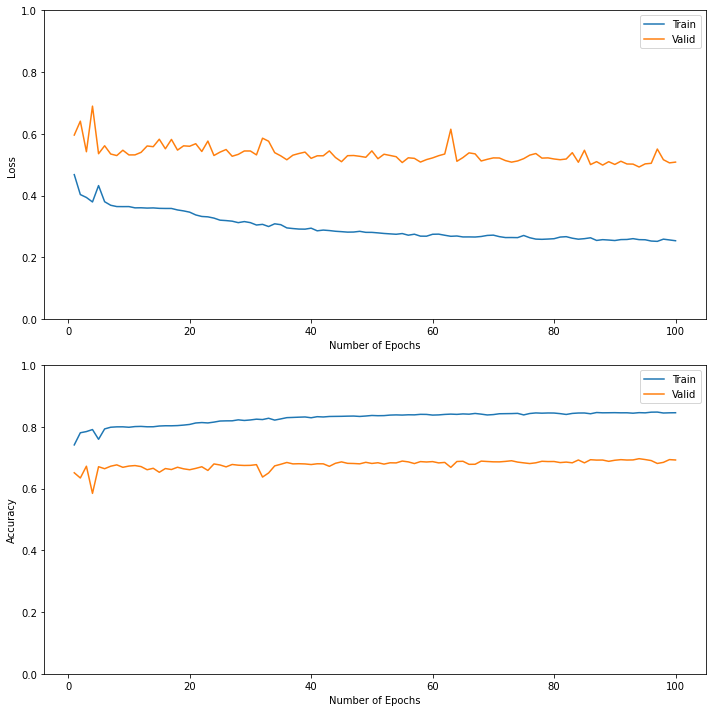

In [26]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.6852    0.9477    0.7953      6061
         1.0     0.9154    0.5652    0.6989      6069

    accuracy                         0.7563     12130
   macro avg     0.8003    0.7564    0.7471     12130
weighted avg     0.8004    0.7563    0.7471     12130



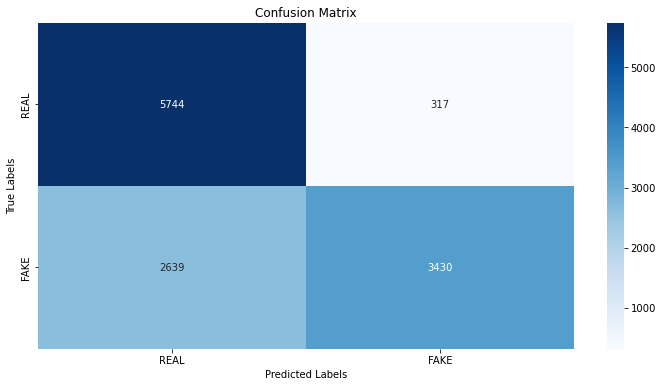

In [27]:
best_model = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

#### Pretrained Word Embeddings: GloVe

In [28]:
text_field.build_vocab(training, min_freq=2, vectors = vocab.Vectors('glove.6B.300d.txt'))

embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1

pretrained_embeddings = text_field.vocab.vectors
model_glove = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model_glove.embedding.weight.data = pretrained_embeddings.cuda()
model_glove.embedding.weight.requires_grad = False
optimizer = optim.Adam(model_glove.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model_glove, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.5209, Validation Loss: 0.7013, Train Acc: 0.7126, Validation Acc: 0.6050
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.4656, Validation Loss: 0.7711, Train Acc: 0.7459, Validation Acc: 0.5574


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.4258, Validation Loss: 0.6622, Train Acc: 0.7690, Validation Acc: 0.6245
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.4250, Validation Loss: 0.5824, Train Acc: 0.7687, Validation Acc: 0.6461
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.4108, Validation Loss: 0.5856, Train Acc: 0.7748, Validation Acc: 0.6438


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.3965, Validation Loss: 0.5971, Train Acc: 0.7814, Validation Acc: 0.6441


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.3877, Validation Loss: 0.6450, Train Acc: 0.7846, Validation Acc: 0.6301


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.3849, Validation Loss: 0.6013, Train Acc: 0.7865, Validation Acc: 0.6443


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.3786, Validation Loss: 0.5913, Train Acc: 0.7888, Validation Acc: 0.6471


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.3697, Validation Loss: 0.5630, Train Acc: 0.7937, Validation Acc: 0.6533
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.3566, Validation Loss: 0.5945, Train Acc: 0.7982, Validation Acc: 0.6448


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.3559, Validation Loss: 0.6239, Train Acc: 0.8006, Validation Acc: 0.6297


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.3496, Validation Loss: 0.6287, Train Acc: 0.8018, Validation Acc: 0.6252


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.3443, Validation Loss: 0.6102, Train Acc: 0.8048, Validation Acc: 0.6520


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.3418, Validation Loss: 0.5943, Train Acc: 0.8052, Validation Acc: 0.6534


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.3335, Validation Loss: 0.5803, Train Acc: 0.8091, Validation Acc: 0.6522


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.3343, Validation Loss: 0.5757, Train Acc: 0.8098, Validation Acc: 0.6531


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.3396, Validation Loss: 0.5686, Train Acc: 0.8063, Validation Acc: 0.6517


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.3232, Validation Loss: 0.5567, Train Acc: 0.8144, Validation Acc: 0.6603
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.3219, Validation Loss: 0.5469, Train Acc: 0.8155, Validation Acc: 0.6640
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.3202, Validation Loss: 0.5509, Train Acc: 0.8164, Validation Acc: 0.6649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.3177, Validation Loss: 0.5519, Train Acc: 0.8166, Validation Acc: 0.6666


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.3140, Validation Loss: 0.5778, Train Acc: 0.8178, Validation Acc: 0.6522


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.3074, Validation Loss: 0.5504, Train Acc: 0.8208, Validation Acc: 0.6722


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.3026, Validation Loss: 0.5321, Train Acc: 0.8239, Validation Acc: 0.6784
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.3059, Validation Loss: 0.5375, Train Acc: 0.8245, Validation Acc: 0.6773


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.3048, Validation Loss: 0.5655, Train Acc: 0.8222, Validation Acc: 0.6598


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.3002, Validation Loss: 0.5760, Train Acc: 0.8239, Validation Acc: 0.6627


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.2943, Validation Loss: 0.6130, Train Acc: 0.8265, Validation Acc: 0.6503


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.2937, Validation Loss: 0.5498, Train Acc: 0.8276, Validation Acc: 0.6738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.2950, Validation Loss: 0.5269, Train Acc: 0.8267, Validation Acc: 0.6828
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.2907, Validation Loss: 0.5435, Train Acc: 0.8292, Validation Acc: 0.6756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.2955, Validation Loss: 0.5407, Train Acc: 0.8267, Validation Acc: 0.6780


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.2889, Validation Loss: 0.5788, Train Acc: 0.8292, Validation Acc: 0.6575


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.2920, Validation Loss: 0.5107, Train Acc: 0.8295, Validation Acc: 0.6866
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.2802, Validation Loss: 0.5155, Train Acc: 0.8335, Validation Acc: 0.6905


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.2733, Validation Loss: 0.5344, Train Acc: 0.8368, Validation Acc: 0.6838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.2763, Validation Loss: 0.6396, Train Acc: 0.8354, Validation Acc: 0.6478


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.2831, Validation Loss: 0.5489, Train Acc: 0.8320, Validation Acc: 0.6735


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.2803, Validation Loss: 0.5225, Train Acc: 0.8340, Validation Acc: 0.6854


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.2800, Validation Loss: 0.5195, Train Acc: 0.8348, Validation Acc: 0.6807


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.2793, Validation Loss: 0.5318, Train Acc: 0.8341, Validation Acc: 0.6815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.2773, Validation Loss: 0.5753, Train Acc: 0.8346, Validation Acc: 0.6713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.2731, Validation Loss: 0.5477, Train Acc: 0.8358, Validation Acc: 0.6850


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.2809, Validation Loss: 0.5462, Train Acc: 0.8327, Validation Acc: 0.6822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.2806, Validation Loss: 0.5178, Train Acc: 0.8332, Validation Acc: 0.6908


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.2778, Validation Loss: 0.5232, Train Acc: 0.8355, Validation Acc: 0.6886


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.2713, Validation Loss: 0.5796, Train Acc: 0.8370, Validation Acc: 0.6768


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.2767, Validation Loss: 0.5380, Train Acc: 0.8357, Validation Acc: 0.6752


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.2788, Validation Loss: 0.5522, Train Acc: 0.8340, Validation Acc: 0.6785


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.2656, Validation Loss: 0.5141, Train Acc: 0.8395, Validation Acc: 0.6901


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.2691, Validation Loss: 0.5442, Train Acc: 0.8397, Validation Acc: 0.6682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.2798, Validation Loss: 0.5504, Train Acc: 0.8329, Validation Acc: 0.6833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.2671, Validation Loss: 0.5424, Train Acc: 0.8399, Validation Acc: 0.6850


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.2684, Validation Loss: 0.5446, Train Acc: 0.8386, Validation Acc: 0.6859


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.2670, Validation Loss: 0.6264, Train Acc: 0.8398, Validation Acc: 0.6585


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.2659, Validation Loss: 0.5638, Train Acc: 0.8396, Validation Acc: 0.6814


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.2641, Validation Loss: 0.5111, Train Acc: 0.8412, Validation Acc: 0.6863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.2605, Validation Loss: 0.5441, Train Acc: 0.8416, Validation Acc: 0.6880


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.2611, Validation Loss: 0.5240, Train Acc: 0.8424, Validation Acc: 0.6893


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.2593, Validation Loss: 0.5655, Train Acc: 0.8418, Validation Acc: 0.6819


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.2618, Validation Loss: 0.5362, Train Acc: 0.8412, Validation Acc: 0.6868


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.2671, Validation Loss: 0.5715, Train Acc: 0.8396, Validation Acc: 0.6722


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.2655, Validation Loss: 0.5088, Train Acc: 0.8403, Validation Acc: 0.6896
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.2593, Validation Loss: 0.5170, Train Acc: 0.8423, Validation Acc: 0.6912


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.2570, Validation Loss: 0.5238, Train Acc: 0.8437, Validation Acc: 0.6882


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.2598, Validation Loss: 0.6327, Train Acc: 0.8416, Validation Acc: 0.6670


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.2611, Validation Loss: 0.5306, Train Acc: 0.8422, Validation Acc: 0.6870


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.2544, Validation Loss: 0.5440, Train Acc: 0.8449, Validation Acc: 0.6824


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.2531, Validation Loss: 0.5504, Train Acc: 0.8459, Validation Acc: 0.6836


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.2594, Validation Loss: 0.5279, Train Acc: 0.8422, Validation Acc: 0.6891


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.2568, Validation Loss: 0.5410, Train Acc: 0.8435, Validation Acc: 0.6863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.2542, Validation Loss: 0.5443, Train Acc: 0.8443, Validation Acc: 0.6815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.2525, Validation Loss: 0.5168, Train Acc: 0.8462, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.2536, Validation Loss: 0.5491, Train Acc: 0.8453, Validation Acc: 0.6736


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.2608, Validation Loss: 0.5398, Train Acc: 0.8425, Validation Acc: 0.6768


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.2603, Validation Loss: 0.5142, Train Acc: 0.8427, Validation Acc: 0.6893


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.2557, Validation Loss: 0.5179, Train Acc: 0.8438, Validation Acc: 0.6908


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.2567, Validation Loss: 0.5614, Train Acc: 0.8434, Validation Acc: 0.6798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.2620, Validation Loss: 0.5450, Train Acc: 0.8412, Validation Acc: 0.6840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.2551, Validation Loss: 0.5331, Train Acc: 0.8452, Validation Acc: 0.6896


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.2501, Validation Loss: 0.5986, Train Acc: 0.8464, Validation Acc: 0.6743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.2490, Validation Loss: 0.5248, Train Acc: 0.8473, Validation Acc: 0.6929


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.2490, Validation Loss: 0.5564, Train Acc: 0.8471, Validation Acc: 0.6764


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.2601, Validation Loss: 0.5399, Train Acc: 0.8421, Validation Acc: 0.6856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.2527, Validation Loss: 0.5533, Train Acc: 0.8446, Validation Acc: 0.6861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.2567, Validation Loss: 0.5138, Train Acc: 0.8433, Validation Acc: 0.6836


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.2516, Validation Loss: 0.5506, Train Acc: 0.8452, Validation Acc: 0.6828


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.2551, Validation Loss: 0.5252, Train Acc: 0.8442, Validation Acc: 0.6859


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.2472, Validation Loss: 0.5280, Train Acc: 0.8480, Validation Acc: 0.6924


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.2501, Validation Loss: 0.6494, Train Acc: 0.8467, Validation Acc: 0.6654


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.2483, Validation Loss: 0.5706, Train Acc: 0.8471, Validation Acc: 0.6854


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.2576, Validation Loss: 0.5365, Train Acc: 0.8436, Validation Acc: 0.6880


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.2617, Validation Loss: 1.4416, Train Acc: 0.8439, Validation Acc: 0.5605


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.2680, Validation Loss: 0.5240, Train Acc: 0.8391, Validation Acc: 0.6808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.2484, Validation Loss: 0.5334, Train Acc: 0.8470, Validation Acc: 0.6868


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.2440, Validation Loss: 0.5347, Train Acc: 0.8483, Validation Acc: 0.6893


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.2498, Validation Loss: 0.5161, Train Acc: 0.8471, Validation Acc: 0.6856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.2567, Validation Loss: 0.5566, Train Acc: 0.8427, Validation Acc: 0.6880


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.2529, Validation Loss: 0.5415, Train Acc: 0.8468, Validation Acc: 0.6761
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


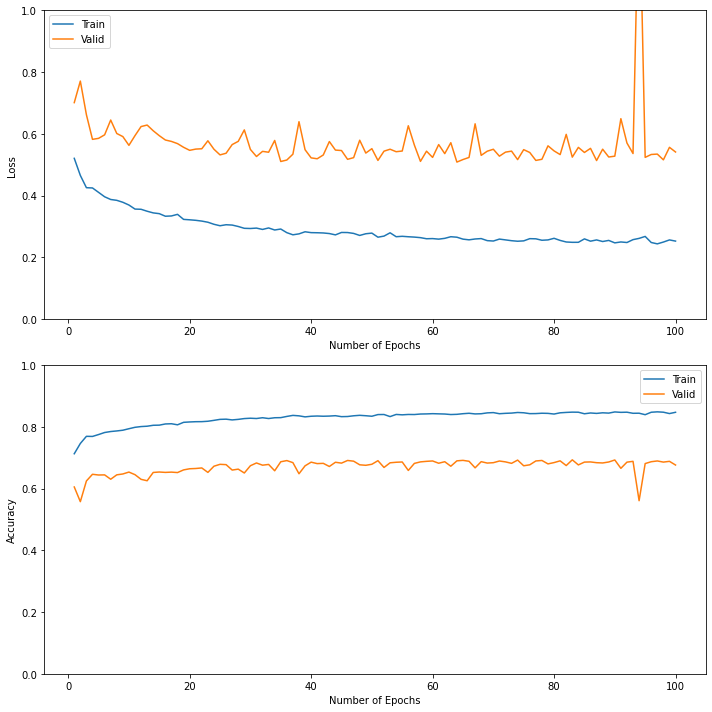

In [29]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.6840    0.9185    0.7841      6061
         1.0     0.8762    0.5762    0.6952      6069

    accuracy                         0.7472     12130
   macro avg     0.7801    0.7474    0.7397     12130
weighted avg     0.7802    0.7472    0.7396     12130



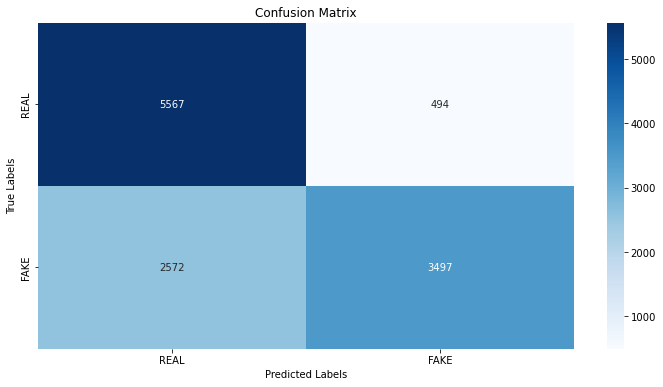

In [30]:
best_model = model_glove
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

#### Pretrained Word Embeddings: FastText

In [31]:
text_field.build_vocab(training, min_freq=2, vectors = vocab.Vectors('data/wiki-news-300d-1M.vec'))

embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1

pretrained_embeddings = text_field.vocab.vectors
model_ft = GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model_ft.embedding.weight.data = pretrained_embeddings.cuda()
model_ft.embedding.weight.requires_grad = False
optimizer = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model_ft, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.5813, Validation Loss: 0.6558, Train Acc: 0.6788, Validation Acc: 0.6182
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.4664, Validation Loss: 0.6157, Train Acc: 0.7484, Validation Acc: 0.6350
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.4497, Validation Loss: 0.6008, Train Acc: 0.7579, Validation Acc: 0.6413
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.4356, Validation Loss: 0.5706, Train Acc: 0.7669, Validation Acc: 0.6568
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.4268, Validation Loss: 0.5651, Train Acc: 0.7721, Validation Acc: 0.6526
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.4246, Validation Loss: 0.5925, Train Acc: 0.7726, Validation Acc: 0.6520


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.4166, Validation Loss: 0.5805, Train Acc: 0.7760, Validation Acc: 0.6476


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.4177, Validation Loss: 0.5809, Train Acc: 0.7750, Validation Acc: 0.6571


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.4100, Validation Loss: 0.5773, Train Acc: 0.7796, Validation Acc: 0.6522


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.4145, Validation Loss: 0.6520, Train Acc: 0.7776, Validation Acc: 0.5867


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.4128, Validation Loss: 0.6228, Train Acc: 0.7791, Validation Acc: 0.6352


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.4377, Validation Loss: 0.6890, Train Acc: 0.7616, Validation Acc: 0.5557


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.4110, Validation Loss: 0.6264, Train Acc: 0.7765, Validation Acc: 0.6053


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.4068, Validation Loss: 0.5519, Train Acc: 0.7786, Validation Acc: 0.6705
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.4051, Validation Loss: 0.5588, Train Acc: 0.7788, Validation Acc: 0.6612


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.4080, Validation Loss: 0.6403, Train Acc: 0.7801, Validation Acc: 0.6408


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.4101, Validation Loss: 0.5936, Train Acc: 0.7769, Validation Acc: 0.6540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.4042, Validation Loss: 0.6135, Train Acc: 0.7797, Validation Acc: 0.6394


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.4079, Validation Loss: 1.2158, Train Acc: 0.7784, Validation Acc: 0.5070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.4486, Validation Loss: 0.5789, Train Acc: 0.7554, Validation Acc: 0.6501


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.4034, Validation Loss: 0.5447, Train Acc: 0.7811, Validation Acc: 0.6675
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.4000, Validation Loss: 0.5522, Train Acc: 0.7814, Validation Acc: 0.6627


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.3974, Validation Loss: 0.5904, Train Acc: 0.7820, Validation Acc: 0.6492


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.3984, Validation Loss: 0.5363, Train Acc: 0.7835, Validation Acc: 0.6692
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.3934, Validation Loss: 0.5958, Train Acc: 0.7857, Validation Acc: 0.6408


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.3929, Validation Loss: 0.5479, Train Acc: 0.7861, Validation Acc: 0.6636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.3879, Validation Loss: 0.5603, Train Acc: 0.7881, Validation Acc: 0.6561


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.3843, Validation Loss: 0.5762, Train Acc: 0.7907, Validation Acc: 0.6522


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.3849, Validation Loss: 0.5742, Train Acc: 0.7894, Validation Acc: 0.6540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.3808, Validation Loss: 0.5371, Train Acc: 0.7917, Validation Acc: 0.6670


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.3750, Validation Loss: 0.5450, Train Acc: 0.7944, Validation Acc: 0.6633


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.3729, Validation Loss: 0.5784, Train Acc: 0.7924, Validation Acc: 0.6540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.3716, Validation Loss: 0.5246, Train Acc: 0.7948, Validation Acc: 0.6756
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.3673, Validation Loss: 0.5569, Train Acc: 0.7965, Validation Acc: 0.6599


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.3694, Validation Loss: 0.5333, Train Acc: 0.7964, Validation Acc: 0.6699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.3660, Validation Loss: 0.5498, Train Acc: 0.7981, Validation Acc: 0.6620


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.3622, Validation Loss: 0.5339, Train Acc: 0.7992, Validation Acc: 0.6713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.3612, Validation Loss: 0.5189, Train Acc: 0.8000, Validation Acc: 0.6828
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.3586, Validation Loss: 0.5141, Train Acc: 0.8012, Validation Acc: 0.6838
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.3576, Validation Loss: 0.5230, Train Acc: 0.8005, Validation Acc: 0.6794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.3557, Validation Loss: 0.5594, Train Acc: 0.8019, Validation Acc: 0.6571


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.3597, Validation Loss: 0.5309, Train Acc: 0.7991, Validation Acc: 0.6738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.3579, Validation Loss: 0.5324, Train Acc: 0.8001, Validation Acc: 0.6729


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.3567, Validation Loss: 0.5150, Train Acc: 0.8006, Validation Acc: 0.6824


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.3510, Validation Loss: 0.5180, Train Acc: 0.8039, Validation Acc: 0.6812


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.3502, Validation Loss: 0.5178, Train Acc: 0.8039, Validation Acc: 0.6831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.3489, Validation Loss: 0.5151, Train Acc: 0.8045, Validation Acc: 0.6810


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.3459, Validation Loss: 0.5216, Train Acc: 0.8057, Validation Acc: 0.6796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.3447, Validation Loss: 0.5132, Train Acc: 0.8065, Validation Acc: 0.6833
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.3450, Validation Loss: 0.5140, Train Acc: 0.8062, Validation Acc: 0.6831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.3418, Validation Loss: 0.5366, Train Acc: 0.8080, Validation Acc: 0.6752


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.3422, Validation Loss: 0.5110, Train Acc: 0.8091, Validation Acc: 0.6842
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.3390, Validation Loss: 0.5120, Train Acc: 0.8100, Validation Acc: 0.6822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.3373, Validation Loss: 0.5140, Train Acc: 0.8104, Validation Acc: 0.6822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.3342, Validation Loss: 0.5143, Train Acc: 0.8113, Validation Acc: 0.6810


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.3360, Validation Loss: 0.5231, Train Acc: 0.8109, Validation Acc: 0.6784


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.3348, Validation Loss: 0.5170, Train Acc: 0.8116, Validation Acc: 0.6796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.3305, Validation Loss: 0.5137, Train Acc: 0.8145, Validation Acc: 0.6835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.3309, Validation Loss: 0.5234, Train Acc: 0.8138, Validation Acc: 0.6792


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.3297, Validation Loss: 0.5156, Train Acc: 0.8137, Validation Acc: 0.6831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.3295, Validation Loss: 0.5163, Train Acc: 0.8148, Validation Acc: 0.6824


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.3300, Validation Loss: 0.5185, Train Acc: 0.8141, Validation Acc: 0.6808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.3317, Validation Loss: 0.5134, Train Acc: 0.8140, Validation Acc: 0.6826


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.3268, Validation Loss: 0.5129, Train Acc: 0.8156, Validation Acc: 0.6843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.3277, Validation Loss: 0.5234, Train Acc: 0.8161, Validation Acc: 0.6768


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.3273, Validation Loss: 0.5627, Train Acc: 0.8159, Validation Acc: 0.6524


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.3236, Validation Loss: 0.5143, Train Acc: 0.8170, Validation Acc: 0.6842


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.3206, Validation Loss: 0.5268, Train Acc: 0.8184, Validation Acc: 0.6743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.3223, Validation Loss: 0.5124, Train Acc: 0.8168, Validation Acc: 0.6822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.3211, Validation Loss: 0.5198, Train Acc: 0.8192, Validation Acc: 0.6785


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.3217, Validation Loss: 0.5155, Train Acc: 0.8173, Validation Acc: 0.6817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.3191, Validation Loss: 0.5188, Train Acc: 0.8185, Validation Acc: 0.6808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.3187, Validation Loss: 0.5247, Train Acc: 0.8185, Validation Acc: 0.6749


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.3194, Validation Loss: 0.5240, Train Acc: 0.8196, Validation Acc: 0.6789


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.3187, Validation Loss: 0.5177, Train Acc: 0.8180, Validation Acc: 0.6787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.3191, Validation Loss: 0.5200, Train Acc: 0.8187, Validation Acc: 0.6817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.3176, Validation Loss: 0.5155, Train Acc: 0.8189, Validation Acc: 0.6822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.3136, Validation Loss: 0.5144, Train Acc: 0.8204, Validation Acc: 0.6838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.3122, Validation Loss: 0.5336, Train Acc: 0.8192, Validation Acc: 0.6710


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.3136, Validation Loss: 0.5171, Train Acc: 0.8205, Validation Acc: 0.6819


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.3133, Validation Loss: 0.5183, Train Acc: 0.8223, Validation Acc: 0.6787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.3080, Validation Loss: 0.5221, Train Acc: 0.8238, Validation Acc: 0.6764


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.3107, Validation Loss: 0.5159, Train Acc: 0.8223, Validation Acc: 0.6840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.3104, Validation Loss: 0.5156, Train Acc: 0.8220, Validation Acc: 0.6808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.3101, Validation Loss: 0.5095, Train Acc: 0.8218, Validation Acc: 0.6840
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.3105, Validation Loss: 0.5181, Train Acc: 0.8232, Validation Acc: 0.6821


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.3094, Validation Loss: 0.5222, Train Acc: 0.8224, Validation Acc: 0.6784


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.3137, Validation Loss: 0.5255, Train Acc: 0.8190, Validation Acc: 0.6798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.3146, Validation Loss: 0.5120, Train Acc: 0.8190, Validation Acc: 0.6828


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.3066, Validation Loss: 0.5141, Train Acc: 0.8242, Validation Acc: 0.6810


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.3075, Validation Loss: 0.5263, Train Acc: 0.8233, Validation Acc: 0.6789


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.3056, Validation Loss: 0.5187, Train Acc: 0.8242, Validation Acc: 0.6796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.3043, Validation Loss: 0.6213, Train Acc: 0.8242, Validation Acc: 0.6387


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.3090, Validation Loss: 0.5202, Train Acc: 0.8230, Validation Acc: 0.6826


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.3075, Validation Loss: 0.5179, Train Acc: 0.8219, Validation Acc: 0.6814


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.3036, Validation Loss: 0.5129, Train Acc: 0.8237, Validation Acc: 0.6838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.3022, Validation Loss: 0.5190, Train Acc: 0.8260, Validation Acc: 0.6803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.3042, Validation Loss: 0.5120, Train Acc: 0.8247, Validation Acc: 0.6838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.3047, Validation Loss: 0.5159, Train Acc: 0.8252, Validation Acc: 0.6828


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.3069, Validation Loss: 0.5172, Train Acc: 0.8230, Validation Acc: 0.6843
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


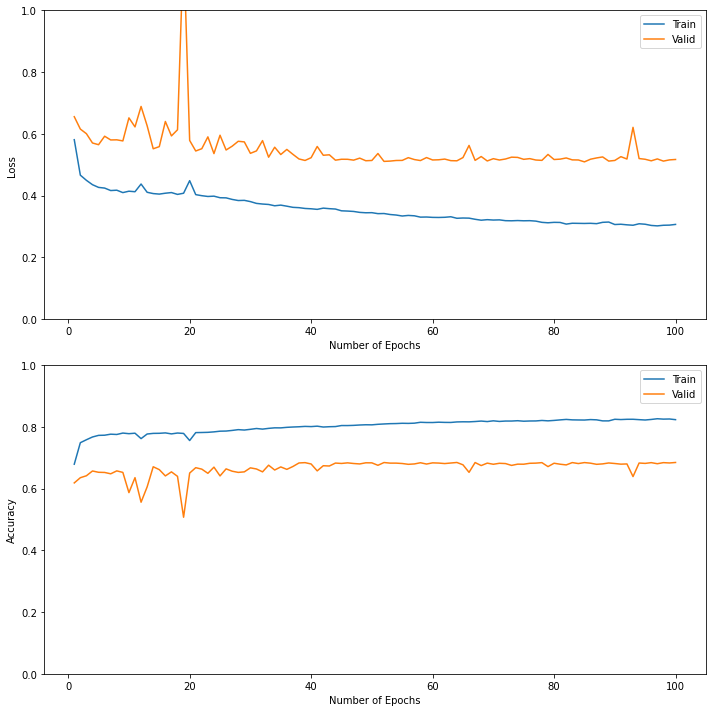

In [32]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.6784    0.9343    0.7860      6061
         1.0     0.8948    0.5576    0.6870      6069

    accuracy                         0.7458     12130
   macro avg     0.7866    0.7460    0.7365     12130
weighted avg     0.7866    0.7458    0.7365     12130



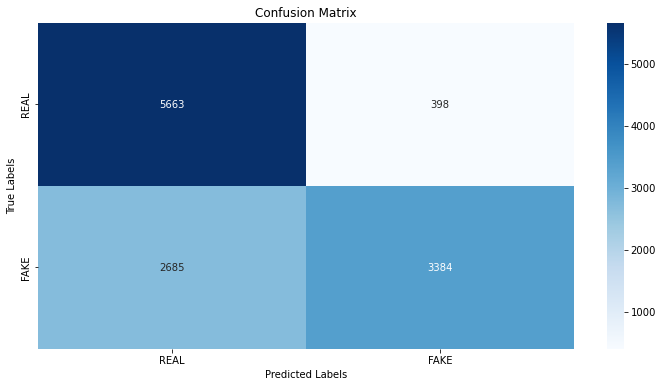

In [33]:
best_model = model_ft
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

### Bidirectional GRU
---

#### Word Embeddings

In [34]:
text_field.build_vocab(training, min_freq=2)

# For reproducibility
seed_everything()

# GRU
embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1


model = B_GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.3225, Validation Loss: 0.5444, Train Acc: 0.8569, Validation Acc: 0.7749
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.2300, Validation Loss: 0.4267, Train Acc: 0.9074, Validation Acc: 0.8448
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.2090, Validation Loss: 0.2981, Train Acc: 0.9156, Validation Acc: 0.8780
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.1939, Validation Loss: 0.8332, Train Acc: 0.9219, Validation Acc: 0.5888


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.2105, Validation Loss: 0.4928, Train Acc: 0.9147, Validation Acc: 0.8100


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.1825, Validation Loss: 0.4566, Train Acc: 0.9269, Validation Acc: 0.8327


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.1579, Validation Loss: 0.2377, Train Acc: 0.9388, Validation Acc: 0.9078
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.1498, Validation Loss: 0.2915, Train Acc: 0.9429, Validation Acc: 0.8759


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.1507, Validation Loss: 0.2273, Train Acc: 0.9415, Validation Acc: 0.9106
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.1485, Validation Loss: 0.3527, Train Acc: 0.9443, Validation Acc: 0.8531


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.1396, Validation Loss: 0.1767, Train Acc: 0.9462, Validation Acc: 0.9289
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.1376, Validation Loss: 1.2328, Train Acc: 0.9498, Validation Acc: 0.5590


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.1668, Validation Loss: 0.7700, Train Acc: 0.9328, Validation Acc: 0.7718


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.1414, Validation Loss: 0.1908, Train Acc: 0.9451, Validation Acc: 0.9314


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.1250, Validation Loss: 0.1937, Train Acc: 0.9514, Validation Acc: 0.9235


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.1150, Validation Loss: 0.2795, Train Acc: 0.9552, Validation Acc: 0.8920


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.1078, Validation Loss: 0.1819, Train Acc: 0.9588, Validation Acc: 0.9294


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.0981, Validation Loss: 0.1728, Train Acc: 0.9624, Validation Acc: 0.9317
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.0957, Validation Loss: 0.2607, Train Acc: 0.9637, Validation Acc: 0.9043


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.0918, Validation Loss: 0.2439, Train Acc: 0.9668, Validation Acc: 0.9106


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.0904, Validation Loss: 0.2060, Train Acc: 0.9653, Validation Acc: 0.9282


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.0845, Validation Loss: 0.1770, Train Acc: 0.9676, Validation Acc: 0.9336


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.0815, Validation Loss: 0.2047, Train Acc: 0.9701, Validation Acc: 0.9296


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.0802, Validation Loss: 0.2092, Train Acc: 0.9700, Validation Acc: 0.9296


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.0738, Validation Loss: 0.2543, Train Acc: 0.9737, Validation Acc: 0.9175


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.0752, Validation Loss: 0.2516, Train Acc: 0.9729, Validation Acc: 0.9182


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.0730, Validation Loss: 0.1615, Train Acc: 0.9735, Validation Acc: 0.9400
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.0667, Validation Loss: 0.1482, Train Acc: 0.9763, Validation Acc: 0.9389
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.0632, Validation Loss: 0.1693, Train Acc: 0.9775, Validation Acc: 0.9368


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.0612, Validation Loss: 0.1448, Train Acc: 0.9778, Validation Acc: 0.9426
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.0687, Validation Loss: 0.3417, Train Acc: 0.9756, Validation Acc: 0.9020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.0640, Validation Loss: 0.1730, Train Acc: 0.9756, Validation Acc: 0.9357


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.0562, Validation Loss: 0.1546, Train Acc: 0.9792, Validation Acc: 0.9400


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.0585, Validation Loss: 0.1592, Train Acc: 0.9791, Validation Acc: 0.9364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.0531, Validation Loss: 0.2047, Train Acc: 0.9808, Validation Acc: 0.9222


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.0493, Validation Loss: 0.1744, Train Acc: 0.9829, Validation Acc: 0.9387


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.0483, Validation Loss: 0.1673, Train Acc: 0.9827, Validation Acc: 0.9362


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.0434, Validation Loss: 0.1811, Train Acc: 0.9851, Validation Acc: 0.9357


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.0469, Validation Loss: 0.1575, Train Acc: 0.9834, Validation Acc: 0.9421


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.0488, Validation Loss: 0.1508, Train Acc: 0.9830, Validation Acc: 0.9419


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.0484, Validation Loss: 0.1617, Train Acc: 0.9831, Validation Acc: 0.9349


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.0500, Validation Loss: 0.1565, Train Acc: 0.9825, Validation Acc: 0.9417


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.0450, Validation Loss: 0.1578, Train Acc: 0.9841, Validation Acc: 0.9368


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.0437, Validation Loss: 0.1649, Train Acc: 0.9857, Validation Acc: 0.9385


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.0382, Validation Loss: 0.1901, Train Acc: 0.9871, Validation Acc: 0.9345


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.0450, Validation Loss: 0.1618, Train Acc: 0.9841, Validation Acc: 0.9350


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.0449, Validation Loss: 0.1444, Train Acc: 0.9847, Validation Acc: 0.9438
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.0398, Validation Loss: 0.1604, Train Acc: 0.9858, Validation Acc: 0.9396


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.0356, Validation Loss: 0.1788, Train Acc: 0.9884, Validation Acc: 0.9354


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.0317, Validation Loss: 0.1852, Train Acc: 0.9898, Validation Acc: 0.9373


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.0348, Validation Loss: 0.2596, Train Acc: 0.9889, Validation Acc: 0.9263


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.0418, Validation Loss: 0.1726, Train Acc: 0.9856, Validation Acc: 0.9321


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.0452, Validation Loss: 0.1596, Train Acc: 0.9854, Validation Acc: 0.9396


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.0352, Validation Loss: 0.2219, Train Acc: 0.9886, Validation Acc: 0.9324


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.0296, Validation Loss: 0.1799, Train Acc: 0.9900, Validation Acc: 0.9363


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.0383, Validation Loss: 0.2048, Train Acc: 0.9876, Validation Acc: 0.9253


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.0435, Validation Loss: 0.1684, Train Acc: 0.9845, Validation Acc: 0.9420


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.0363, Validation Loss: 0.2022, Train Acc: 0.9876, Validation Acc: 0.9345


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.0323, Validation Loss: 0.1820, Train Acc: 0.9892, Validation Acc: 0.9342


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.0345, Validation Loss: 0.1919, Train Acc: 0.9887, Validation Acc: 0.9301


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.0336, Validation Loss: 0.1953, Train Acc: 0.9882, Validation Acc: 0.9368


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.0316, Validation Loss: 0.1651, Train Acc: 0.9898, Validation Acc: 0.9356


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.0327, Validation Loss: 0.1858, Train Acc: 0.9891, Validation Acc: 0.9342


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.0333, Validation Loss: 0.1612, Train Acc: 0.9886, Validation Acc: 0.9403


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.0320, Validation Loss: 0.1949, Train Acc: 0.9902, Validation Acc: 0.9387


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.0335, Validation Loss: 0.1680, Train Acc: 0.9891, Validation Acc: 0.9377


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.0330, Validation Loss: 0.1878, Train Acc: 0.9900, Validation Acc: 0.9340


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.0380, Validation Loss: 0.1979, Train Acc: 0.9875, Validation Acc: 0.9322


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.0352, Validation Loss: 0.1761, Train Acc: 0.9878, Validation Acc: 0.9445


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.0334, Validation Loss: 0.1651, Train Acc: 0.9891, Validation Acc: 0.9424


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.0280, Validation Loss: 0.1650, Train Acc: 0.9920, Validation Acc: 0.9415


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.0269, Validation Loss: 1.6415, Train Acc: 0.9911, Validation Acc: 0.7040


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.0477, Validation Loss: 0.2510, Train Acc: 0.9822, Validation Acc: 0.9192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.0405, Validation Loss: 0.1679, Train Acc: 0.9865, Validation Acc: 0.9380


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.0308, Validation Loss: 0.2751, Train Acc: 0.9898, Validation Acc: 0.9087


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.0281, Validation Loss: 0.1755, Train Acc: 0.9910, Validation Acc: 0.9386


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.0294, Validation Loss: 0.1752, Train Acc: 0.9908, Validation Acc: 0.9403


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.0302, Validation Loss: 0.2543, Train Acc: 0.9898, Validation Acc: 0.9219


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.0387, Validation Loss: 0.1894, Train Acc: 0.9872, Validation Acc: 0.9240


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.0372, Validation Loss: 0.1972, Train Acc: 0.9873, Validation Acc: 0.9363


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.0322, Validation Loss: 0.1494, Train Acc: 0.9899, Validation Acc: 0.9408


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.0312, Validation Loss: 0.2241, Train Acc: 0.9901, Validation Acc: 0.9264


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.0242, Validation Loss: 0.2329, Train Acc: 0.9925, Validation Acc: 0.9311


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.0247, Validation Loss: 0.2040, Train Acc: 0.9917, Validation Acc: 0.9389


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.0282, Validation Loss: 0.1724, Train Acc: 0.9908, Validation Acc: 0.9398


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.0288, Validation Loss: 0.1602, Train Acc: 0.9915, Validation Acc: 0.9443


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.0253, Validation Loss: 0.1959, Train Acc: 0.9924, Validation Acc: 0.9397


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.0254, Validation Loss: 0.2293, Train Acc: 0.9915, Validation Acc: 0.9345


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.0252, Validation Loss: 0.1830, Train Acc: 0.9915, Validation Acc: 0.9413


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.0289, Validation Loss: 0.1731, Train Acc: 0.9906, Validation Acc: 0.9412


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.0312, Validation Loss: 0.1925, Train Acc: 0.9896, Validation Acc: 0.9368


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.0347, Validation Loss: 0.1488, Train Acc: 0.9893, Validation Acc: 0.9449


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.0300, Validation Loss: 0.1630, Train Acc: 0.9906, Validation Acc: 0.9438


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.0260, Validation Loss: 0.1813, Train Acc: 0.9918, Validation Acc: 0.9429


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.0250, Validation Loss: 0.1874, Train Acc: 0.9917, Validation Acc: 0.9369


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.0266, Validation Loss: 0.1865, Train Acc: 0.9914, Validation Acc: 0.9396


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.0257, Validation Loss: 0.1801, Train Acc: 0.9914, Validation Acc: 0.9440


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.0266, Validation Loss: 0.1740, Train Acc: 0.9912, Validation Acc: 0.9450


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.0279, Validation Loss: 0.1713, Train Acc: 0.9913, Validation Acc: 0.9456


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.0304, Validation Loss: 0.1803, Train Acc: 0.9896, Validation Acc: 0.9403
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


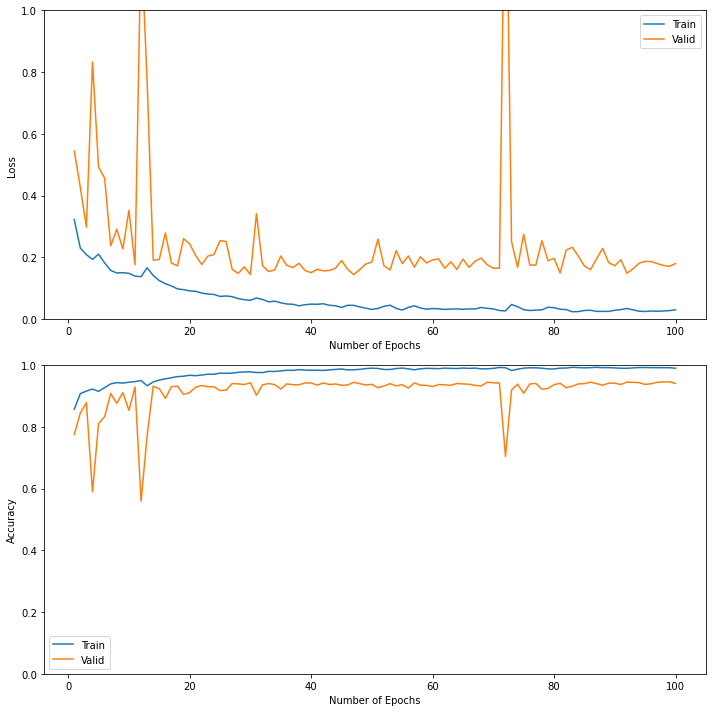

In [35]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9471    0.9333    0.9402      6061
         1.0     0.9344    0.9479    0.9411      6069

    accuracy                         0.9406     12130
   macro avg     0.9407    0.9406    0.9406     12130
weighted avg     0.9407    0.9406    0.9406     12130



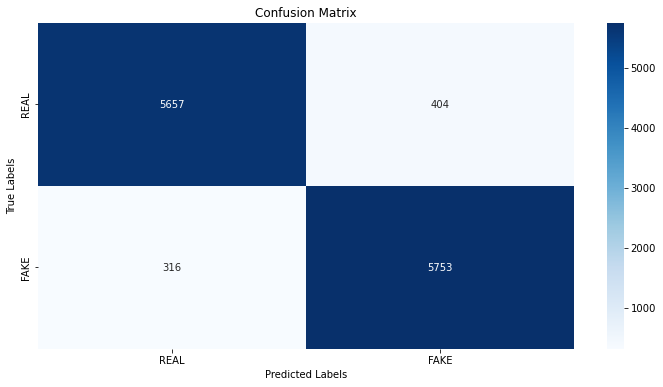

In [36]:
best_model = B_GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

#### Pretrained Word Embeddings: GloVe

In [37]:
text_field.build_vocab(training, min_freq=2, vectors = vocab.Vectors('data/glove.6B.300d.txt'))

embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1

pretrained_embeddings = text_field.vocab.vectors
model_glove = B_GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model_glove.embedding.weight.data = pretrained_embeddings.cuda()
model_glove.embedding.weight.requires_grad = False
optimizer = optim.Adam(model_glove.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model_glove, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.3732, Validation Loss: 0.3591, Train Acc: 0.8292, Validation Acc: 0.8330
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.2916, Validation Loss: 0.3666, Train Acc: 0.8731, Validation Acc: 0.8283


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.2535, Validation Loss: 0.4320, Train Acc: 0.8923, Validation Acc: 0.7953


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.2444, Validation Loss: 0.4288, Train Acc: 0.8981, Validation Acc: 0.7962


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.2273, Validation Loss: 0.4392, Train Acc: 0.9054, Validation Acc: 0.8065


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.2142, Validation Loss: 0.3210, Train Acc: 0.9108, Validation Acc: 0.8546
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.1976, Validation Loss: 0.4940, Train Acc: 0.9195, Validation Acc: 0.7814


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.1938, Validation Loss: 0.2982, Train Acc: 0.9191, Validation Acc: 0.8722
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.1818, Validation Loss: 0.3303, Train Acc: 0.9267, Validation Acc: 0.8581


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.1830, Validation Loss: 0.3145, Train Acc: 0.9264, Validation Acc: 0.8531


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.1737, Validation Loss: 0.3149, Train Acc: 0.9299, Validation Acc: 0.8569


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.1716, Validation Loss: 0.4695, Train Acc: 0.9292, Validation Acc: 0.8069


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.1625, Validation Loss: 0.4672, Train Acc: 0.9331, Validation Acc: 0.8061


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.1554, Validation Loss: 0.3022, Train Acc: 0.9357, Validation Acc: 0.8685


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.1415, Validation Loss: 0.3214, Train Acc: 0.9420, Validation Acc: 0.8580


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.1424, Validation Loss: 0.2866, Train Acc: 0.9409, Validation Acc: 0.8729
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.1326, Validation Loss: 0.3040, Train Acc: 0.9465, Validation Acc: 0.8660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.1286, Validation Loss: 0.4011, Train Acc: 0.9478, Validation Acc: 0.8311


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.1240, Validation Loss: 0.2711, Train Acc: 0.9497, Validation Acc: 0.8836
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.1156, Validation Loss: 0.2850, Train Acc: 0.9550, Validation Acc: 0.8810


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.1091, Validation Loss: 0.3410, Train Acc: 0.9563, Validation Acc: 0.8571


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.1172, Validation Loss: 0.2306, Train Acc: 0.9533, Validation Acc: 0.9036
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.1063, Validation Loss: 0.3148, Train Acc: 0.9578, Validation Acc: 0.8638


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.1027, Validation Loss: 0.3784, Train Acc: 0.9589, Validation Acc: 0.8520


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.0988, Validation Loss: 0.3184, Train Acc: 0.9610, Validation Acc: 0.8730


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.1021, Validation Loss: 0.3421, Train Acc: 0.9599, Validation Acc: 0.8755


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.0969, Validation Loss: 0.3093, Train Acc: 0.9607, Validation Acc: 0.8751


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.0983, Validation Loss: 0.3248, Train Acc: 0.9617, Validation Acc: 0.8699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.0996, Validation Loss: 0.2339, Train Acc: 0.9601, Validation Acc: 0.9075


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.0905, Validation Loss: 0.2745, Train Acc: 0.9646, Validation Acc: 0.8889


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.0878, Validation Loss: 0.2534, Train Acc: 0.9657, Validation Acc: 0.8992


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.0846, Validation Loss: 0.2270, Train Acc: 0.9662, Validation Acc: 0.9091
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.0814, Validation Loss: 0.3121, Train Acc: 0.9683, Validation Acc: 0.8769


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.0770, Validation Loss: 0.2797, Train Acc: 0.9708, Validation Acc: 0.8934


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.0765, Validation Loss: 0.3081, Train Acc: 0.9709, Validation Acc: 0.8840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.0785, Validation Loss: 0.2728, Train Acc: 0.9696, Validation Acc: 0.8985


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.0818, Validation Loss: 0.2017, Train Acc: 0.9684, Validation Acc: 0.9178
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.0753, Validation Loss: 0.3706, Train Acc: 0.9714, Validation Acc: 0.8682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.0755, Validation Loss: 0.4633, Train Acc: 0.9720, Validation Acc: 0.8377


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.0671, Validation Loss: 0.3782, Train Acc: 0.9745, Validation Acc: 0.8748


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.0649, Validation Loss: 0.4463, Train Acc: 0.9758, Validation Acc: 0.8669


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.0658, Validation Loss: 0.3512, Train Acc: 0.9760, Validation Acc: 0.8850


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.0618, Validation Loss: 0.4668, Train Acc: 0.9766, Validation Acc: 0.8462


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.0659, Validation Loss: 0.3813, Train Acc: 0.9747, Validation Acc: 0.8743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.0629, Validation Loss: 0.2856, Train Acc: 0.9770, Validation Acc: 0.9068


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.0602, Validation Loss: 0.3762, Train Acc: 0.9782, Validation Acc: 0.8787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.0532, Validation Loss: 0.3880, Train Acc: 0.9804, Validation Acc: 0.8822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.0589, Validation Loss: 0.2781, Train Acc: 0.9782, Validation Acc: 0.9017


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.0572, Validation Loss: 0.2507, Train Acc: 0.9784, Validation Acc: 0.9152


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.0571, Validation Loss: 0.4108, Train Acc: 0.9780, Validation Acc: 0.8710


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.0547, Validation Loss: 0.5947, Train Acc: 0.9807, Validation Acc: 0.8465


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.0541, Validation Loss: 0.3990, Train Acc: 0.9797, Validation Acc: 0.8880


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.0519, Validation Loss: 0.3538, Train Acc: 0.9800, Validation Acc: 0.8813


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.0552, Validation Loss: 0.4230, Train Acc: 0.9787, Validation Acc: 0.8709


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.0587, Validation Loss: 0.2882, Train Acc: 0.9779, Validation Acc: 0.9052


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.0607, Validation Loss: 0.2614, Train Acc: 0.9769, Validation Acc: 0.9027


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.0575, Validation Loss: 0.3377, Train Acc: 0.9781, Validation Acc: 0.8903


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.0540, Validation Loss: 0.3617, Train Acc: 0.9801, Validation Acc: 0.8750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.0577, Validation Loss: 0.2296, Train Acc: 0.9785, Validation Acc: 0.9233


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.0488, Validation Loss: 0.3785, Train Acc: 0.9815, Validation Acc: 0.8862


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.0484, Validation Loss: 0.2994, Train Acc: 0.9828, Validation Acc: 0.8961


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.0561, Validation Loss: 0.6275, Train Acc: 0.9782, Validation Acc: 0.8391


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.0487, Validation Loss: 0.3369, Train Acc: 0.9828, Validation Acc: 0.8991


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.0509, Validation Loss: 0.3830, Train Acc: 0.9818, Validation Acc: 0.8894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.0454, Validation Loss: 0.4989, Train Acc: 0.9834, Validation Acc: 0.8700


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.0434, Validation Loss: 0.2600, Train Acc: 0.9849, Validation Acc: 0.9168


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.0421, Validation Loss: 0.3661, Train Acc: 0.9849, Validation Acc: 0.8895


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.0409, Validation Loss: 0.2163, Train Acc: 0.9857, Validation Acc: 0.9264


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.0428, Validation Loss: 0.2877, Train Acc: 0.9842, Validation Acc: 0.9145


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.0413, Validation Loss: 0.3558, Train Acc: 0.9855, Validation Acc: 0.8885


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.0438, Validation Loss: 0.4466, Train Acc: 0.9842, Validation Acc: 0.8808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.0429, Validation Loss: 0.4494, Train Acc: 0.9846, Validation Acc: 0.8857


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.0464, Validation Loss: 0.4183, Train Acc: 0.9828, Validation Acc: 0.8785


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.0475, Validation Loss: 0.3865, Train Acc: 0.9823, Validation Acc: 0.8765


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.0447, Validation Loss: 0.2866, Train Acc: 0.9844, Validation Acc: 0.9089


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.0413, Validation Loss: 0.2239, Train Acc: 0.9847, Validation Acc: 0.9271


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.0442, Validation Loss: 0.4438, Train Acc: 0.9839, Validation Acc: 0.8838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.0463, Validation Loss: 0.2576, Train Acc: 0.9827, Validation Acc: 0.9236


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.0365, Validation Loss: 0.5698, Train Acc: 0.9874, Validation Acc: 0.8530


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.0429, Validation Loss: 0.4660, Train Acc: 0.9847, Validation Acc: 0.8831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.0435, Validation Loss: 0.4465, Train Acc: 0.9844, Validation Acc: 0.8838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.0371, Validation Loss: 0.4842, Train Acc: 0.9863, Validation Acc: 0.8755


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.0388, Validation Loss: 0.4106, Train Acc: 0.9868, Validation Acc: 0.8833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.0375, Validation Loss: 0.4579, Train Acc: 0.9871, Validation Acc: 0.8873


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.0332, Validation Loss: 0.4461, Train Acc: 0.9883, Validation Acc: 0.8957


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.0377, Validation Loss: 0.3186, Train Acc: 0.9865, Validation Acc: 0.9124


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.0405, Validation Loss: 0.2600, Train Acc: 0.9856, Validation Acc: 0.9182


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.0414, Validation Loss: 0.4240, Train Acc: 0.9863, Validation Acc: 0.8915


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.0407, Validation Loss: 0.3721, Train Acc: 0.9859, Validation Acc: 0.8843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.0382, Validation Loss: 0.5565, Train Acc: 0.9871, Validation Acc: 0.8689


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.0454, Validation Loss: 0.5332, Train Acc: 0.9853, Validation Acc: 0.8525


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.0609, Validation Loss: 0.4841, Train Acc: 0.9769, Validation Acc: 0.8573


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.0366, Validation Loss: 0.2716, Train Acc: 0.9871, Validation Acc: 0.9187


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.0329, Validation Loss: 0.4166, Train Acc: 0.9889, Validation Acc: 0.8973


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.0305, Validation Loss: 0.4363, Train Acc: 0.9898, Validation Acc: 0.8955


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.0303, Validation Loss: 0.4265, Train Acc: 0.9896, Validation Acc: 0.9013


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.0350, Validation Loss: 0.2599, Train Acc: 0.9876, Validation Acc: 0.9252


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.0377, Validation Loss: 0.5903, Train Acc: 0.9867, Validation Acc: 0.8569


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.0383, Validation Loss: 0.5295, Train Acc: 0.9868, Validation Acc: 0.8523


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.0356, Validation Loss: 0.3170, Train Acc: 0.9872, Validation Acc: 0.9034
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


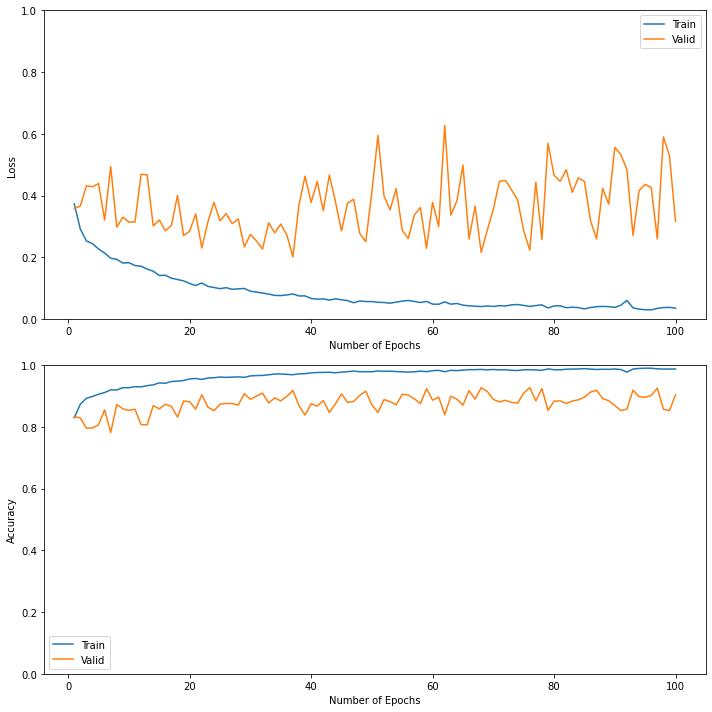

In [38]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9460    0.8792    0.9114      6061
         1.0     0.8873    0.9499    0.9176      6069

    accuracy                         0.9146     12130
   macro avg     0.9167    0.9146    0.9145     12130
weighted avg     0.9167    0.9146    0.9145     12130



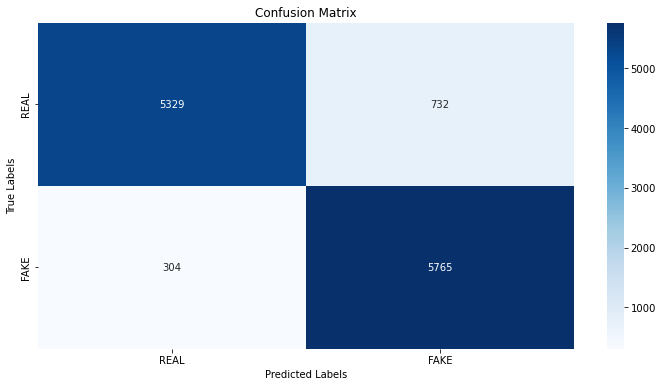

In [39]:
best_model = model_glove
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

#### Pretrained Word Embeddings: FastText

In [40]:
text_field.build_vocab(training, min_freq=2, vectors = vocab.Vectors('data/wiki-news-300d-1M.vec'))

embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1

pretrained_embeddings = text_field.vocab.vectors
model_ft = B_GRU(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model_ft.embedding.weight.data = pretrained_embeddings.cuda()
model_ft.embedding.weight.requires_grad = False
optimizer = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model_ft, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.4208, Validation Loss: 1.1125, Train Acc: 0.7940, Validation Acc: 0.7116
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.2987, Validation Loss: 0.3262, Train Acc: 0.8756, Validation Acc: 0.8555
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.2817, Validation Loss: 0.4037, Train Acc: 0.8817, Validation Acc: 0.8102


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.2706, Validation Loss: 0.5753, Train Acc: 0.8904, Validation Acc: 0.6803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.2701, Validation Loss: 0.3340, Train Acc: 0.8893, Validation Acc: 0.8517


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.2672, Validation Loss: 0.4510, Train Acc: 0.8925, Validation Acc: 0.7719


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.2521, Validation Loss: 0.3073, Train Acc: 0.8968, Validation Acc: 0.8638
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.2505, Validation Loss: 0.3370, Train Acc: 0.8992, Validation Acc: 0.8434


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.2455, Validation Loss: 0.4387, Train Acc: 0.9015, Validation Acc: 0.7841


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.2392, Validation Loss: 0.2859, Train Acc: 0.9039, Validation Acc: 0.8736
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.2373, Validation Loss: 0.4191, Train Acc: 0.9061, Validation Acc: 0.8044


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.2371, Validation Loss: 0.3032, Train Acc: 0.9038, Validation Acc: 0.8659


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.2340, Validation Loss: 0.2736, Train Acc: 0.9061, Validation Acc: 0.8778
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.2306, Validation Loss: 0.2552, Train Acc: 0.9077, Validation Acc: 0.8885
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.2196, Validation Loss: 0.3070, Train Acc: 0.9124, Validation Acc: 0.8573


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.2198, Validation Loss: 0.3026, Train Acc: 0.9123, Validation Acc: 0.8608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.2137, Validation Loss: 0.2494, Train Acc: 0.9169, Validation Acc: 0.8919
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.2115, Validation Loss: 0.2356, Train Acc: 0.9157, Validation Acc: 0.8989
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.2093, Validation Loss: 0.2342, Train Acc: 0.9175, Validation Acc: 0.9001
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.2039, Validation Loss: 0.2296, Train Acc: 0.9187, Validation Acc: 0.9022
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.1977, Validation Loss: 0.2292, Train Acc: 0.9218, Validation Acc: 0.9005
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.1957, Validation Loss: 0.2792, Train Acc: 0.9220, Validation Acc: 0.8761


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.1967, Validation Loss: 0.2362, Train Acc: 0.9222, Validation Acc: 0.8996


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.1894, Validation Loss: 0.2288, Train Acc: 0.9244, Validation Acc: 0.8999
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.1847, Validation Loss: 0.2187, Train Acc: 0.9273, Validation Acc: 0.9091
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.1818, Validation Loss: 0.2578, Train Acc: 0.9295, Validation Acc: 0.8906


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.1781, Validation Loss: 0.2174, Train Acc: 0.9309, Validation Acc: 0.9087
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.1747, Validation Loss: 0.2136, Train Acc: 0.9309, Validation Acc: 0.9126
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.1776, Validation Loss: 0.2077, Train Acc: 0.9310, Validation Acc: 0.9124
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.1729, Validation Loss: 0.2085, Train Acc: 0.9323, Validation Acc: 0.9143


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.1653, Validation Loss: 0.1984, Train Acc: 0.9357, Validation Acc: 0.9145
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.1598, Validation Loss: 0.2772, Train Acc: 0.9376, Validation Acc: 0.8782


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.1620, Validation Loss: 0.2130, Train Acc: 0.9365, Validation Acc: 0.9055


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.1587, Validation Loss: 0.2042, Train Acc: 0.9375, Validation Acc: 0.9159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.1586, Validation Loss: 0.2024, Train Acc: 0.9388, Validation Acc: 0.9171


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.1517, Validation Loss: 0.2110, Train Acc: 0.9402, Validation Acc: 0.9105


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.1503, Validation Loss: 0.1964, Train Acc: 0.9420, Validation Acc: 0.9164
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.1455, Validation Loss: 0.2823, Train Acc: 0.9441, Validation Acc: 0.8790


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.1463, Validation Loss: 0.1934, Train Acc: 0.9439, Validation Acc: 0.9164
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.1446, Validation Loss: 0.6705, Train Acc: 0.9442, Validation Acc: 0.7117


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.1475, Validation Loss: 0.2146, Train Acc: 0.9425, Validation Acc: 0.9110


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.1454, Validation Loss: 0.2013, Train Acc: 0.9425, Validation Acc: 0.9182


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.1404, Validation Loss: 0.1954, Train Acc: 0.9454, Validation Acc: 0.9187


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.1356, Validation Loss: 0.1994, Train Acc: 0.9484, Validation Acc: 0.9180


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.1340, Validation Loss: 0.2097, Train Acc: 0.9481, Validation Acc: 0.9161


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.1314, Validation Loss: 0.2092, Train Acc: 0.9488, Validation Acc: 0.9163


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.1380, Validation Loss: 0.1901, Train Acc: 0.9465, Validation Acc: 0.9217
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.1294, Validation Loss: 0.1911, Train Acc: 0.9490, Validation Acc: 0.9233


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.1341, Validation Loss: 1.6053, Train Acc: 0.9496, Validation Acc: 0.5762


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.1436, Validation Loss: 0.2187, Train Acc: 0.9424, Validation Acc: 0.9015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.1315, Validation Loss: 0.1986, Train Acc: 0.9495, Validation Acc: 0.9189


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.1281, Validation Loss: 0.4623, Train Acc: 0.9502, Validation Acc: 0.8035


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.1330, Validation Loss: 0.1970, Train Acc: 0.9489, Validation Acc: 0.9171


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.1326, Validation Loss: 0.1949, Train Acc: 0.9477, Validation Acc: 0.9168


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.1309, Validation Loss: 0.1919, Train Acc: 0.9491, Validation Acc: 0.9201


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.1291, Validation Loss: 0.2112, Train Acc: 0.9503, Validation Acc: 0.9092


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.1237, Validation Loss: 0.2025, Train Acc: 0.9530, Validation Acc: 0.9136


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.1221, Validation Loss: 0.3163, Train Acc: 0.9547, Validation Acc: 0.8682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.1257, Validation Loss: 0.1981, Train Acc: 0.9511, Validation Acc: 0.9154


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.1172, Validation Loss: 0.1925, Train Acc: 0.9551, Validation Acc: 0.9226


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.1161, Validation Loss: 0.2082, Train Acc: 0.9563, Validation Acc: 0.9101


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.1157, Validation Loss: 0.1845, Train Acc: 0.9552, Validation Acc: 0.9222
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.1130, Validation Loss: 0.2246, Train Acc: 0.9583, Validation Acc: 0.9085


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.1157, Validation Loss: 0.1916, Train Acc: 0.9557, Validation Acc: 0.9224


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.1189, Validation Loss: 0.1829, Train Acc: 0.9555, Validation Acc: 0.9222
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.1192, Validation Loss: 0.1828, Train Acc: 0.9545, Validation Acc: 0.9263
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.1077, Validation Loss: 0.1794, Train Acc: 0.9587, Validation Acc: 0.9233
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.1061, Validation Loss: 0.1970, Train Acc: 0.9607, Validation Acc: 0.9170


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.1060, Validation Loss: 0.1868, Train Acc: 0.9601, Validation Acc: 0.9219


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.1044, Validation Loss: 0.1920, Train Acc: 0.9612, Validation Acc: 0.9192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.1027, Validation Loss: 0.2273, Train Acc: 0.9611, Validation Acc: 0.9070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.1033, Validation Loss: 0.1877, Train Acc: 0.9612, Validation Acc: 0.9206


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.1033, Validation Loss: 0.2217, Train Acc: 0.9618, Validation Acc: 0.9068


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.1091, Validation Loss: 0.2619, Train Acc: 0.9593, Validation Acc: 0.8922


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.1104, Validation Loss: 0.1938, Train Acc: 0.9575, Validation Acc: 0.9168


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.1085, Validation Loss: 0.1942, Train Acc: 0.9590, Validation Acc: 0.9173


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.1016, Validation Loss: 0.2201, Train Acc: 0.9615, Validation Acc: 0.9110


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.1021, Validation Loss: 0.2303, Train Acc: 0.9620, Validation Acc: 0.9029


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.1007, Validation Loss: 0.2002, Train Acc: 0.9616, Validation Acc: 0.9187


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.0988, Validation Loss: 0.1850, Train Acc: 0.9635, Validation Acc: 0.9231


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.0998, Validation Loss: 0.1868, Train Acc: 0.9627, Validation Acc: 0.9213


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.1015, Validation Loss: 0.1906, Train Acc: 0.9620, Validation Acc: 0.9222


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.1017, Validation Loss: 0.1876, Train Acc: 0.9618, Validation Acc: 0.9192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.0977, Validation Loss: 0.1829, Train Acc: 0.9631, Validation Acc: 0.9250


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.0990, Validation Loss: 0.1955, Train Acc: 0.9623, Validation Acc: 0.9187


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.0973, Validation Loss: 0.1879, Train Acc: 0.9633, Validation Acc: 0.9231


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.0986, Validation Loss: 0.2370, Train Acc: 0.9638, Validation Acc: 0.8996


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.0994, Validation Loss: 0.1886, Train Acc: 0.9621, Validation Acc: 0.9201


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.0999, Validation Loss: 0.2272, Train Acc: 0.9630, Validation Acc: 0.9057


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.0998, Validation Loss: 0.1901, Train Acc: 0.9620, Validation Acc: 0.9224


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.0953, Validation Loss: 0.2177, Train Acc: 0.9649, Validation Acc: 0.9140


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.0920, Validation Loss: 0.1886, Train Acc: 0.9655, Validation Acc: 0.9228


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.0934, Validation Loss: 0.1859, Train Acc: 0.9643, Validation Acc: 0.9247


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.0944, Validation Loss: 0.2202, Train Acc: 0.9652, Validation Acc: 0.9119


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.0904, Validation Loss: 0.2372, Train Acc: 0.9661, Validation Acc: 0.9033


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.0871, Validation Loss: 0.1971, Train Acc: 0.9670, Validation Acc: 0.9240


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.0860, Validation Loss: 0.1890, Train Acc: 0.9681, Validation Acc: 0.9224


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.0858, Validation Loss: 0.7243, Train Acc: 0.9677, Validation Acc: 0.8064


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.0979, Validation Loss: 0.4466, Train Acc: 0.9624, Validation Acc: 0.8427


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.0914, Validation Loss: 0.2820, Train Acc: 0.9657, Validation Acc: 0.8910
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


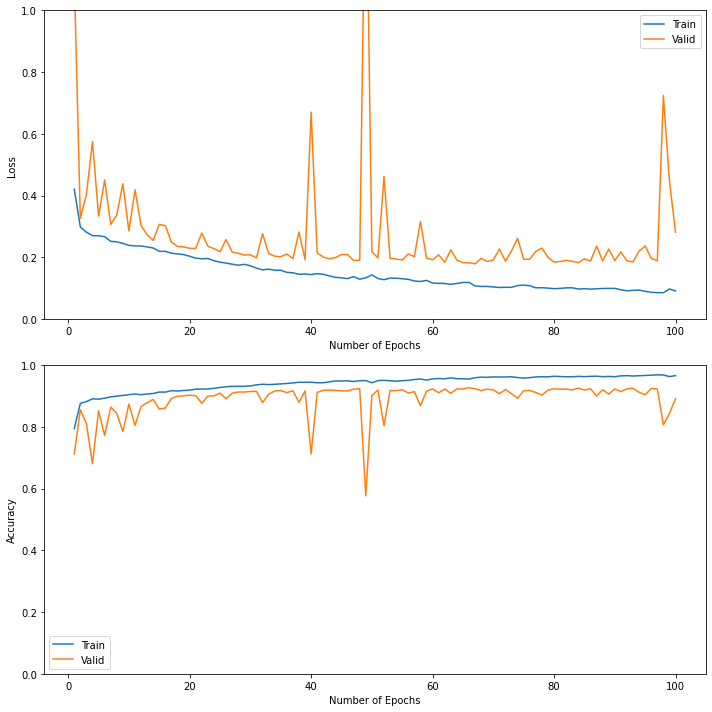

In [41]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9368    0.9144    0.9254      6061
         1.0     0.9165    0.9384    0.9273      6069

    accuracy                         0.9264     12130
   macro avg     0.9266    0.9264    0.9264     12130
weighted avg     0.9266    0.9264    0.9264     12130



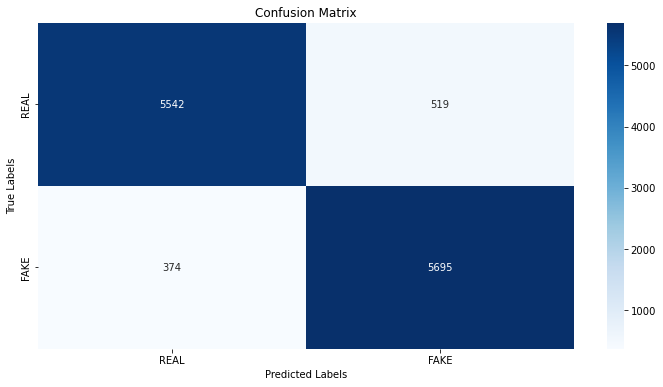

In [42]:
best_model = model_ft
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

### LSTM
---

#### Word Embeddings

In [43]:
text_field.build_vocab(training, min_freq=2)

# for reproducibility
seed_everything()

# LSTM
embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1


model = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.4949, Validation Loss: 0.6185, Train Acc: 0.7283, Validation Acc: 0.6417
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.4081, Validation Loss: 0.6108, Train Acc: 0.7782, Validation Acc: 0.6471
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.3997, Validation Loss: 0.5884, Train Acc: 0.7824, Validation Acc: 0.6505
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.3830, Validation Loss: 0.6047, Train Acc: 0.7878, Validation Acc: 0.6475


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.3712, Validation Loss: 0.5832, Train Acc: 0.7974, Validation Acc: 0.6522
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.3668, Validation Loss: 0.5430, Train Acc: 0.7974, Validation Acc: 0.6677
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.3678, Validation Loss: 0.6091, Train Acc: 0.7980, Validation Acc: 0.6394


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.3684, Validation Loss: 0.5357, Train Acc: 0.7975, Validation Acc: 0.6719
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.3583, Validation Loss: 0.6494, Train Acc: 0.8020, Validation Acc: 0.6410


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.3666, Validation Loss: 0.5512, Train Acc: 0.7979, Validation Acc: 0.6691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.3584, Validation Loss: 0.5211, Train Acc: 0.8023, Validation Acc: 0.6782
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.3503, Validation Loss: 0.5495, Train Acc: 0.8046, Validation Acc: 0.6759


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.3573, Validation Loss: 0.5376, Train Acc: 0.8016, Validation Acc: 0.6694


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.3593, Validation Loss: 0.5519, Train Acc: 0.8014, Validation Acc: 0.6697


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.3505, Validation Loss: 0.5449, Train Acc: 0.8052, Validation Acc: 0.6778


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.3475, Validation Loss: 0.5472, Train Acc: 0.8074, Validation Acc: 0.6738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.3393, Validation Loss: 0.5213, Train Acc: 0.8097, Validation Acc: 0.6859


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.3369, Validation Loss: 0.5081, Train Acc: 0.8106, Validation Acc: 0.6866
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.3384, Validation Loss: 0.5401, Train Acc: 0.8095, Validation Acc: 0.6677


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.3366, Validation Loss: 0.5057, Train Acc: 0.8111, Validation Acc: 0.6900
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.3405, Validation Loss: 0.5634, Train Acc: 0.8103, Validation Acc: 0.6636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.3386, Validation Loss: 0.4995, Train Acc: 0.8098, Validation Acc: 0.6919
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.3238, Validation Loss: 0.5053, Train Acc: 0.8174, Validation Acc: 0.6884


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.3215, Validation Loss: 0.5173, Train Acc: 0.8180, Validation Acc: 0.6871


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.3195, Validation Loss: 0.5019, Train Acc: 0.8185, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.3167, Validation Loss: 0.5204, Train Acc: 0.8201, Validation Acc: 0.6822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.3193, Validation Loss: 0.5078, Train Acc: 0.8173, Validation Acc: 0.6873


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.3172, Validation Loss: 0.5458, Train Acc: 0.8205, Validation Acc: 0.6805


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.3122, Validation Loss: 0.5668, Train Acc: 0.8212, Validation Acc: 0.6668


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.3151, Validation Loss: 0.5197, Train Acc: 0.8184, Validation Acc: 0.6796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.3126, Validation Loss: 0.5189, Train Acc: 0.8206, Validation Acc: 0.6893


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.3110, Validation Loss: 0.5226, Train Acc: 0.8223, Validation Acc: 0.6835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.3074, Validation Loss: 0.5074, Train Acc: 0.8234, Validation Acc: 0.6893


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.3066, Validation Loss: 0.5363, Train Acc: 0.8242, Validation Acc: 0.6847


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.3017, Validation Loss: 0.5352, Train Acc: 0.8252, Validation Acc: 0.6829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.3020, Validation Loss: 0.5179, Train Acc: 0.8251, Validation Acc: 0.6838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.3024, Validation Loss: 0.4917, Train Acc: 0.8253, Validation Acc: 0.6956
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.2990, Validation Loss: 0.5033, Train Acc: 0.8266, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.3095, Validation Loss: 0.5231, Train Acc: 0.8234, Validation Acc: 0.6821


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.3113, Validation Loss: 0.5807, Train Acc: 0.8226, Validation Acc: 0.6555


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.3085, Validation Loss: 0.5456, Train Acc: 0.8227, Validation Acc: 0.6833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.2990, Validation Loss: 0.5482, Train Acc: 0.8276, Validation Acc: 0.6787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.2959, Validation Loss: 0.5193, Train Acc: 0.8275, Validation Acc: 0.6900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.2906, Validation Loss: 0.5104, Train Acc: 0.8314, Validation Acc: 0.6936


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.2879, Validation Loss: 0.5148, Train Acc: 0.8324, Validation Acc: 0.6896


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.2898, Validation Loss: 0.5236, Train Acc: 0.8319, Validation Acc: 0.6847


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.2888, Validation Loss: 0.5001, Train Acc: 0.8310, Validation Acc: 0.6966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.2960, Validation Loss: 0.4998, Train Acc: 0.8297, Validation Acc: 0.6919


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.2943, Validation Loss: 0.5152, Train Acc: 0.8302, Validation Acc: 0.6829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.2995, Validation Loss: 0.5149, Train Acc: 0.8264, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.2919, Validation Loss: 0.4889, Train Acc: 0.8319, Validation Acc: 0.6975
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.2828, Validation Loss: 0.5301, Train Acc: 0.8330, Validation Acc: 0.6852


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.2794, Validation Loss: 0.4969, Train Acc: 0.8363, Validation Acc: 0.6917


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.2773, Validation Loss: 0.5109, Train Acc: 0.8369, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.2788, Validation Loss: 0.5420, Train Acc: 0.8370, Validation Acc: 0.6849


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.2813, Validation Loss: 0.5634, Train Acc: 0.8345, Validation Acc: 0.6761


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.2818, Validation Loss: 0.5070, Train Acc: 0.8362, Validation Acc: 0.6884


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.2834, Validation Loss: 0.5295, Train Acc: 0.8353, Validation Acc: 0.6805


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.2849, Validation Loss: 1.4141, Train Acc: 0.8361, Validation Acc: 0.5126


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.2957, Validation Loss: 0.5027, Train Acc: 0.8303, Validation Acc: 0.6910


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.2859, Validation Loss: 0.5906, Train Acc: 0.8330, Validation Acc: 0.6777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.2828, Validation Loss: 0.5096, Train Acc: 0.8347, Validation Acc: 0.6870


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.2752, Validation Loss: 0.5055, Train Acc: 0.8378, Validation Acc: 0.6947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.2785, Validation Loss: 0.5086, Train Acc: 0.8359, Validation Acc: 0.6933


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.2734, Validation Loss: 0.5289, Train Acc: 0.8399, Validation Acc: 0.6871


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.2712, Validation Loss: 0.5406, Train Acc: 0.8398, Validation Acc: 0.6850


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.2722, Validation Loss: 0.5169, Train Acc: 0.8404, Validation Acc: 0.6854


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.2771, Validation Loss: 0.4943, Train Acc: 0.8380, Validation Acc: 0.6968


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.2679, Validation Loss: 0.5280, Train Acc: 0.8415, Validation Acc: 0.6912


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.2655, Validation Loss: 0.4979, Train Acc: 0.8426, Validation Acc: 0.6956


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.2693, Validation Loss: 0.5091, Train Acc: 0.8406, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.2703, Validation Loss: 0.5068, Train Acc: 0.8410, Validation Acc: 0.6901


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.2662, Validation Loss: 0.5083, Train Acc: 0.8420, Validation Acc: 0.6956


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.2748, Validation Loss: 0.4986, Train Acc: 0.8393, Validation Acc: 0.6893


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.2827, Validation Loss: 0.5051, Train Acc: 0.8349, Validation Acc: 0.6905


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.2650, Validation Loss: 0.5282, Train Acc: 0.8416, Validation Acc: 0.6910


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.2606, Validation Loss: 0.5116, Train Acc: 0.8434, Validation Acc: 0.6901


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.2652, Validation Loss: 0.5100, Train Acc: 0.8419, Validation Acc: 0.6912


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.2679, Validation Loss: 0.5359, Train Acc: 0.8416, Validation Acc: 0.6884


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.2679, Validation Loss: 0.5083, Train Acc: 0.8413, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.2622, Validation Loss: 0.5076, Train Acc: 0.8434, Validation Acc: 0.6912


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.2619, Validation Loss: 0.5062, Train Acc: 0.8443, Validation Acc: 0.6947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.2672, Validation Loss: 0.5399, Train Acc: 0.8415, Validation Acc: 0.6780


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.2726, Validation Loss: 0.4967, Train Acc: 0.8394, Validation Acc: 0.6929


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.2638, Validation Loss: 0.5110, Train Acc: 0.8434, Validation Acc: 0.6903


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.2602, Validation Loss: 0.5240, Train Acc: 0.8449, Validation Acc: 0.6907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.2603, Validation Loss: 0.5054, Train Acc: 0.8447, Validation Acc: 0.6917


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.2648, Validation Loss: 0.4975, Train Acc: 0.8425, Validation Acc: 0.6947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.2596, Validation Loss: 0.5133, Train Acc: 0.8449, Validation Acc: 0.6929


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.2591, Validation Loss: 0.4922, Train Acc: 0.8452, Validation Acc: 0.6973


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.2598, Validation Loss: 0.5153, Train Acc: 0.8444, Validation Acc: 0.6947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.2667, Validation Loss: 0.5013, Train Acc: 0.8423, Validation Acc: 0.6928


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.2697, Validation Loss: 0.4942, Train Acc: 0.8424, Validation Acc: 0.6958


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.2625, Validation Loss: 0.5092, Train Acc: 0.8437, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.2524, Validation Loss: 0.5217, Train Acc: 0.8465, Validation Acc: 0.6907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.2543, Validation Loss: 0.5249, Train Acc: 0.8468, Validation Acc: 0.6907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.2521, Validation Loss: 0.5188, Train Acc: 0.8480, Validation Acc: 0.6917


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.2622, Validation Loss: 0.5013, Train Acc: 0.8434, Validation Acc: 0.6938


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.2628, Validation Loss: 0.5020, Train Acc: 0.8436, Validation Acc: 0.6942


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.2522, Validation Loss: 0.5114, Train Acc: 0.8479, Validation Acc: 0.6936
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


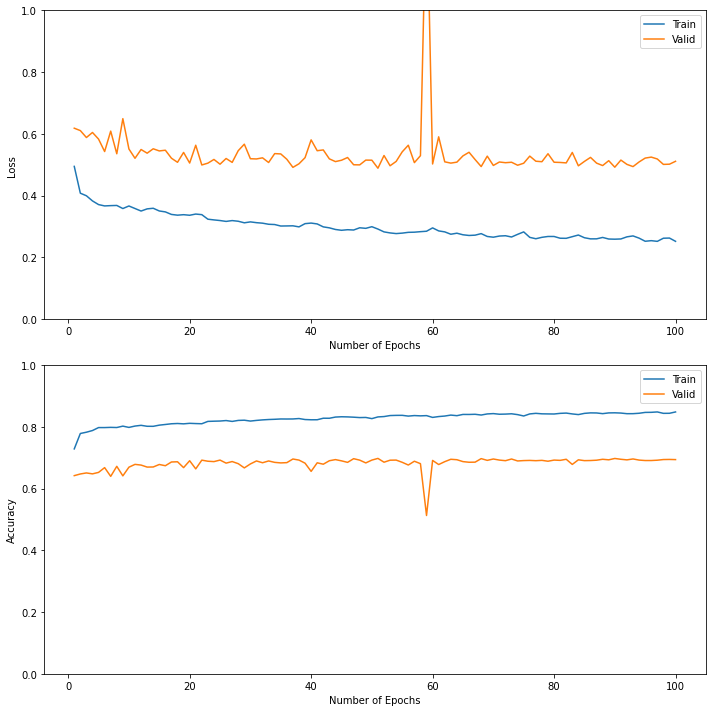

In [44]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.6897    0.9371    0.7946      6061
         1.0     0.9022    0.5788    0.7052      6069

    accuracy                         0.7579     12130
   macro avg     0.7959    0.7580    0.7499     12130
weighted avg     0.7960    0.7579    0.7499     12130



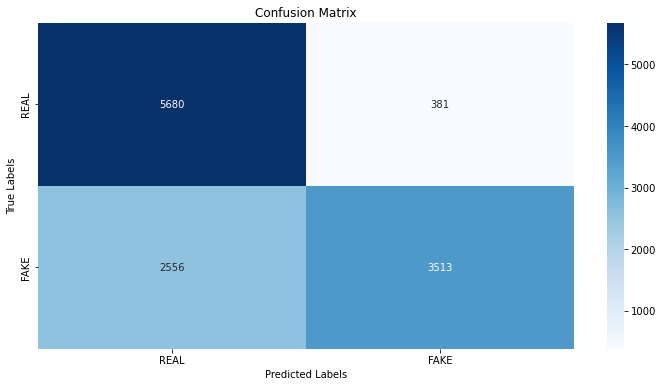

In [45]:
best_model = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

#### Pretrained Word Embeddings: GloVe

In [46]:
text_field.build_vocab(training, min_freq=2, vectors = vocab.Vectors('data/glove.6B.300d.txt'))

embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1

pretrained_embeddings = text_field.vocab.vectors
model_glove = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model_glove.embedding.weight.data = pretrained_embeddings.cuda()
model_glove.embedding.weight.requires_grad = False
optimizer = optim.Adam(model_glove.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model_glove, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.5692, Validation Loss: 0.6898, Train Acc: 0.6845, Validation Acc: 0.5908
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.4643, Validation Loss: 0.6406, Train Acc: 0.7504, Validation Acc: 0.6210
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.4345, Validation Loss: 0.5614, Train Acc: 0.7671, Validation Acc: 0.6573
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.4216, Validation Loss: 0.5629, Train Acc: 0.7730, Validation Acc: 0.6568


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.4189, Validation Loss: 0.5958, Train Acc: 0.7752, Validation Acc: 0.6252


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.4074, Validation Loss: 0.5495, Train Acc: 0.7771, Validation Acc: 0.6682
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.3864, Validation Loss: 0.5797, Train Acc: 0.7873, Validation Acc: 0.6533


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.3904, Validation Loss: 0.5568, Train Acc: 0.7870, Validation Acc: 0.6606


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.3864, Validation Loss: 0.5495, Train Acc: 0.7876, Validation Acc: 0.6684


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.3751, Validation Loss: 0.5921, Train Acc: 0.7932, Validation Acc: 0.6589


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.3779, Validation Loss: 0.6802, Train Acc: 0.7916, Validation Acc: 0.6359


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.3766, Validation Loss: 0.5372, Train Acc: 0.7927, Validation Acc: 0.6729
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.3628, Validation Loss: 0.5296, Train Acc: 0.7968, Validation Acc: 0.6773
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.3668, Validation Loss: 0.5482, Train Acc: 0.7992, Validation Acc: 0.6664


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.3579, Validation Loss: 0.6311, Train Acc: 0.8001, Validation Acc: 0.6436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.3587, Validation Loss: 0.5493, Train Acc: 0.8009, Validation Acc: 0.6736


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.3523, Validation Loss: 0.5686, Train Acc: 0.8031, Validation Acc: 0.6649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.3578, Validation Loss: 0.5641, Train Acc: 0.8019, Validation Acc: 0.6729


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.3441, Validation Loss: 0.6066, Train Acc: 0.8082, Validation Acc: 0.6591


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.3537, Validation Loss: 0.5238, Train Acc: 0.8033, Validation Acc: 0.6801
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.3457, Validation Loss: 0.5877, Train Acc: 0.8064, Validation Acc: 0.6587


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.3424, Validation Loss: 0.6086, Train Acc: 0.8072, Validation Acc: 0.6570


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.3381, Validation Loss: 0.5758, Train Acc: 0.8091, Validation Acc: 0.6687


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.3340, Validation Loss: 0.5653, Train Acc: 0.8113, Validation Acc: 0.6733


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.3328, Validation Loss: 0.5758, Train Acc: 0.8133, Validation Acc: 0.6747


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.3388, Validation Loss: 0.5548, Train Acc: 0.8114, Validation Acc: 0.6713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.3355, Validation Loss: 0.5290, Train Acc: 0.8097, Validation Acc: 0.6817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.3260, Validation Loss: 0.5580, Train Acc: 0.8151, Validation Acc: 0.6728


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.3302, Validation Loss: 0.5748, Train Acc: 0.8126, Validation Acc: 0.6640


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.3255, Validation Loss: 0.5498, Train Acc: 0.8153, Validation Acc: 0.6800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.3238, Validation Loss: 0.5923, Train Acc: 0.8159, Validation Acc: 0.6592


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.3233, Validation Loss: 0.5611, Train Acc: 0.8154, Validation Acc: 0.6782


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.3216, Validation Loss: 0.5707, Train Acc: 0.8179, Validation Acc: 0.6678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.3227, Validation Loss: 0.5282, Train Acc: 0.8163, Validation Acc: 0.6849


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.3149, Validation Loss: 0.5440, Train Acc: 0.8211, Validation Acc: 0.6787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.3120, Validation Loss: 0.5534, Train Acc: 0.8207, Validation Acc: 0.6789


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.3061, Validation Loss: 0.6124, Train Acc: 0.8225, Validation Acc: 0.6613


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.3069, Validation Loss: 0.5957, Train Acc: 0.8231, Validation Acc: 0.6722


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.3070, Validation Loss: 0.5541, Train Acc: 0.8230, Validation Acc: 0.6794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.3000, Validation Loss: 0.5621, Train Acc: 0.8268, Validation Acc: 0.6761


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.3059, Validation Loss: 0.5492, Train Acc: 0.8234, Validation Acc: 0.6814


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.3031, Validation Loss: 0.5332, Train Acc: 0.8269, Validation Acc: 0.6777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.3060, Validation Loss: 0.5190, Train Acc: 0.8239, Validation Acc: 0.6852
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.3040, Validation Loss: 0.5339, Train Acc: 0.8241, Validation Acc: 0.6789


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.3028, Validation Loss: 0.5396, Train Acc: 0.8254, Validation Acc: 0.6821


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.3079, Validation Loss: 0.5542, Train Acc: 0.8242, Validation Acc: 0.6647


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.3083, Validation Loss: 0.5664, Train Acc: 0.8210, Validation Acc: 0.6784


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.2996, Validation Loss: 0.5390, Train Acc: 0.8261, Validation Acc: 0.6835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.2911, Validation Loss: 0.5644, Train Acc: 0.8294, Validation Acc: 0.6798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.2892, Validation Loss: 0.5929, Train Acc: 0.8316, Validation Acc: 0.6757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.2848, Validation Loss: 0.6377, Train Acc: 0.8340, Validation Acc: 0.6596


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.2903, Validation Loss: 0.5398, Train Acc: 0.8310, Validation Acc: 0.6870


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.2836, Validation Loss: 0.5540, Train Acc: 0.8340, Validation Acc: 0.6817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.2852, Validation Loss: 0.5604, Train Acc: 0.8326, Validation Acc: 0.6780


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.2795, Validation Loss: 0.6368, Train Acc: 0.8346, Validation Acc: 0.6601


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.2824, Validation Loss: 0.5855, Train Acc: 0.8331, Validation Acc: 0.6684


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.2839, Validation Loss: 0.5189, Train Acc: 0.8347, Validation Acc: 0.6896
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.2802, Validation Loss: 0.5389, Train Acc: 0.8352, Validation Acc: 0.6831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.2821, Validation Loss: 0.5104, Train Acc: 0.8341, Validation Acc: 0.6914
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.2748, Validation Loss: 0.5893, Train Acc: 0.8377, Validation Acc: 0.6743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.2745, Validation Loss: 0.5370, Train Acc: 0.8384, Validation Acc: 0.6819


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.2758, Validation Loss: 0.5379, Train Acc: 0.8368, Validation Acc: 0.6908


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.2733, Validation Loss: 0.5297, Train Acc: 0.8383, Validation Acc: 0.6922


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.2723, Validation Loss: 0.5727, Train Acc: 0.8391, Validation Acc: 0.6801


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.2760, Validation Loss: 0.5568, Train Acc: 0.8369, Validation Acc: 0.6814


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.2768, Validation Loss: 0.6204, Train Acc: 0.8389, Validation Acc: 0.6371


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.2778, Validation Loss: 0.5017, Train Acc: 0.8354, Validation Acc: 0.6919
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.2738, Validation Loss: 0.5875, Train Acc: 0.8373, Validation Acc: 0.6735


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.2678, Validation Loss: 0.5282, Train Acc: 0.8404, Validation Acc: 0.6921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.2880, Validation Loss: 0.6401, Train Acc: 0.8360, Validation Acc: 0.6175


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.3345, Validation Loss: 0.5185, Train Acc: 0.8081, Validation Acc: 0.6857


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.2839, Validation Loss: 0.5587, Train Acc: 0.8332, Validation Acc: 0.6752


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.2693, Validation Loss: 0.5919, Train Acc: 0.8400, Validation Acc: 0.6789


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.2676, Validation Loss: 0.5158, Train Acc: 0.8412, Validation Acc: 0.6893


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.2659, Validation Loss: 0.5885, Train Acc: 0.8409, Validation Acc: 0.6792


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.2687, Validation Loss: 0.5585, Train Acc: 0.8401, Validation Acc: 0.6819


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.2645, Validation Loss: 0.5789, Train Acc: 0.8411, Validation Acc: 0.6822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.2676, Validation Loss: 0.5421, Train Acc: 0.8403, Validation Acc: 0.6710


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.2694, Validation Loss: 0.5890, Train Acc: 0.8398, Validation Acc: 0.6789


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.2675, Validation Loss: 0.5331, Train Acc: 0.8405, Validation Acc: 0.6879


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.2638, Validation Loss: 0.5592, Train Acc: 0.8421, Validation Acc: 0.6824


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.2704, Validation Loss: 0.5229, Train Acc: 0.8380, Validation Acc: 0.6894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.2639, Validation Loss: 0.5602, Train Acc: 0.8419, Validation Acc: 0.6840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.2619, Validation Loss: 0.5855, Train Acc: 0.8418, Validation Acc: 0.6838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.2614, Validation Loss: 0.5501, Train Acc: 0.8428, Validation Acc: 0.6868


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.2573, Validation Loss: 0.5178, Train Acc: 0.8442, Validation Acc: 0.6907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.2598, Validation Loss: 0.5872, Train Acc: 0.8430, Validation Acc: 0.6800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.2652, Validation Loss: 0.5251, Train Acc: 0.8404, Validation Acc: 0.6773


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.2651, Validation Loss: 0.5498, Train Acc: 0.8405, Validation Acc: 0.6866


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.2551, Validation Loss: 0.5547, Train Acc: 0.8450, Validation Acc: 0.6889


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.2534, Validation Loss: 0.6209, Train Acc: 0.8452, Validation Acc: 0.6763


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.2601, Validation Loss: 0.5436, Train Acc: 0.8429, Validation Acc: 0.6815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.2597, Validation Loss: 0.5831, Train Acc: 0.8435, Validation Acc: 0.6750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.2534, Validation Loss: 0.6500, Train Acc: 0.8460, Validation Acc: 0.6691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.2543, Validation Loss: 0.5848, Train Acc: 0.8454, Validation Acc: 0.6798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.2523, Validation Loss: 0.5051, Train Acc: 0.8460, Validation Acc: 0.6931


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.2553, Validation Loss: 0.5712, Train Acc: 0.8447, Validation Acc: 0.6787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.2612, Validation Loss: 0.6121, Train Acc: 0.8423, Validation Acc: 0.6759


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.2548, Validation Loss: 0.5516, Train Acc: 0.8450, Validation Acc: 0.6829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.2575, Validation Loss: 0.5062, Train Acc: 0.8444, Validation Acc: 0.6945
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


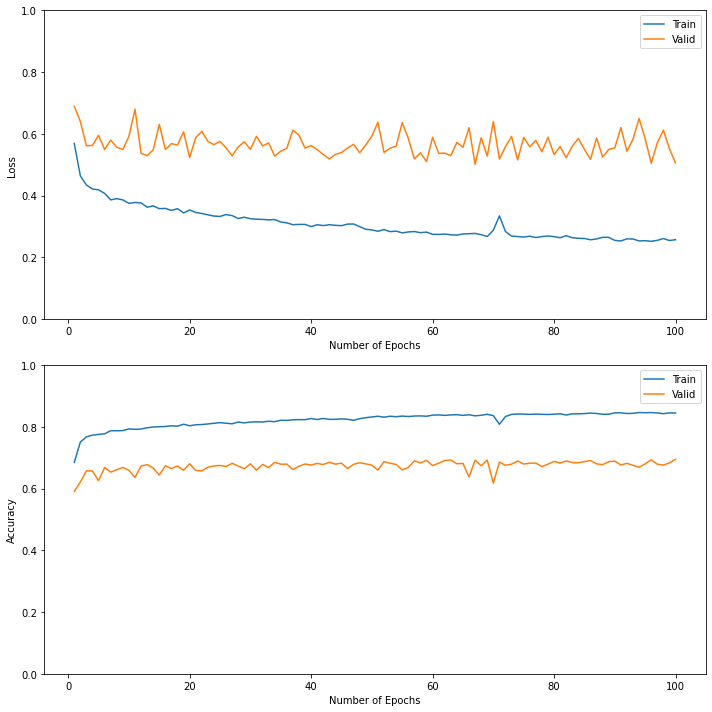

In [47]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.6817    0.9360    0.7888      6061
         1.0     0.8981    0.5635    0.6925      6069

    accuracy                         0.7496     12130
   macro avg     0.7899    0.7498    0.7407     12130
weighted avg     0.7900    0.7496    0.7407     12130



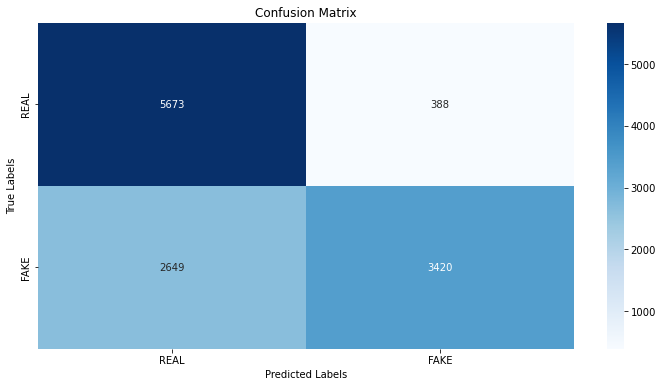

In [48]:
best_model = model_glove
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

#### Pretrained Word Embeddings: FastText

In [49]:
text_field.build_vocab(training, min_freq=2, vectors = vocab.Vectors('data/wiki-news-300d-1M.vec'))

embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1

pretrained_embeddings = text_field.vocab.vectors
model_ft = LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model_ft.embedding.weight.data = pretrained_embeddings.cuda()
model_ft.embedding.weight.requires_grad = False
optimizer = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model_ft, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.6408, Validation Loss: 0.6428, Train Acc: 0.6341, Validation Acc: 0.6231
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.5094, Validation Loss: 0.6261, Train Acc: 0.7265, Validation Acc: 0.6264
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.4761, Validation Loss: 0.6092, Train Acc: 0.7459, Validation Acc: 0.6389
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.4585, Validation Loss: 0.5974, Train Acc: 0.7564, Validation Acc: 0.6382
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.4492, Validation Loss: 0.5834, Train Acc: 0.7571, Validation Acc: 0.6413
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.4474, Validation Loss: 0.6327, Train Acc: 0.7595, Validation Acc: 0.6241


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.4325, Validation Loss: 0.6214, Train Acc: 0.7641, Validation Acc: 0.6364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.4264, Validation Loss: 0.5568, Train Acc: 0.7716, Validation Acc: 0.6605
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.4279, Validation Loss: 0.5558, Train Acc: 0.7714, Validation Acc: 0.6599
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.4206, Validation Loss: 0.5971, Train Acc: 0.7736, Validation Acc: 0.6380


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.4235, Validation Loss: 0.5787, Train Acc: 0.7726, Validation Acc: 0.6562


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.4079, Validation Loss: 0.5821, Train Acc: 0.7798, Validation Acc: 0.6457


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.4098, Validation Loss: 0.6177, Train Acc: 0.7784, Validation Acc: 0.6383


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.4123, Validation Loss: 0.6117, Train Acc: 0.7797, Validation Acc: 0.6427


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.4099, Validation Loss: 0.5964, Train Acc: 0.7801, Validation Acc: 0.6489


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.4064, Validation Loss: 0.5757, Train Acc: 0.7811, Validation Acc: 0.6503


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.4045, Validation Loss: 0.6154, Train Acc: 0.7815, Validation Acc: 0.6436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.4073, Validation Loss: 0.8225, Train Acc: 0.7806, Validation Acc: 0.5083


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.4135, Validation Loss: 0.5909, Train Acc: 0.7775, Validation Acc: 0.6436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.4030, Validation Loss: 0.5907, Train Acc: 0.7833, Validation Acc: 0.6506


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.4050, Validation Loss: 0.5826, Train Acc: 0.7823, Validation Acc: 0.6469


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.3979, Validation Loss: 0.5909, Train Acc: 0.7857, Validation Acc: 0.6438


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.4093, Validation Loss: 0.5934, Train Acc: 0.7804, Validation Acc: 0.6580


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.4028, Validation Loss: 0.5844, Train Acc: 0.7792, Validation Acc: 0.6499


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.3948, Validation Loss: 0.5825, Train Acc: 0.7875, Validation Acc: 0.6448


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.3928, Validation Loss: 0.5842, Train Acc: 0.7875, Validation Acc: 0.6505


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.3860, Validation Loss: 0.6012, Train Acc: 0.7903, Validation Acc: 0.6492


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.3861, Validation Loss: 0.5684, Train Acc: 0.7916, Validation Acc: 0.6545


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.3822, Validation Loss: 0.7191, Train Acc: 0.7918, Validation Acc: 0.5799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.3854, Validation Loss: 0.6237, Train Acc: 0.7921, Validation Acc: 0.6383


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.3853, Validation Loss: 0.6040, Train Acc: 0.7928, Validation Acc: 0.6327


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.3878, Validation Loss: 0.5965, Train Acc: 0.7924, Validation Acc: 0.6396


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.3893, Validation Loss: 0.6014, Train Acc: 0.7872, Validation Acc: 0.6441


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.3807, Validation Loss: 0.6318, Train Acc: 0.7938, Validation Acc: 0.6146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.3782, Validation Loss: 0.5680, Train Acc: 0.7944, Validation Acc: 0.6534


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.3772, Validation Loss: 0.6073, Train Acc: 0.7939, Validation Acc: 0.6340


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.3730, Validation Loss: 0.5626, Train Acc: 0.7965, Validation Acc: 0.6575


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.3786, Validation Loss: 0.6128, Train Acc: 0.7947, Validation Acc: 0.6231


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.3690, Validation Loss: 0.5987, Train Acc: 0.7985, Validation Acc: 0.6350


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.3649, Validation Loss: 0.5706, Train Acc: 0.8006, Validation Acc: 0.6571


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.3617, Validation Loss: 0.5646, Train Acc: 0.8001, Validation Acc: 0.6550


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.3581, Validation Loss: 0.5849, Train Acc: 0.8025, Validation Acc: 0.6483


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.3571, Validation Loss: 0.5660, Train Acc: 0.8016, Validation Acc: 0.6534


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.3548, Validation Loss: 0.6162, Train Acc: 0.8032, Validation Acc: 0.6311


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.3535, Validation Loss: 0.5362, Train Acc: 0.8047, Validation Acc: 0.6703
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.3534, Validation Loss: 0.5598, Train Acc: 0.8057, Validation Acc: 0.6599


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.3502, Validation Loss: 0.5482, Train Acc: 0.8065, Validation Acc: 0.6670


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.3486, Validation Loss: 0.5366, Train Acc: 0.8054, Validation Acc: 0.6713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.3450, Validation Loss: 0.5813, Train Acc: 0.8076, Validation Acc: 0.6469


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.3440, Validation Loss: 0.5847, Train Acc: 0.8095, Validation Acc: 0.6387


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.3458, Validation Loss: 0.5164, Train Acc: 0.8094, Validation Acc: 0.6800
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.3489, Validation Loss: 0.5229, Train Acc: 0.8050, Validation Acc: 0.6829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.3457, Validation Loss: 0.5250, Train Acc: 0.8057, Validation Acc: 0.6785


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.3386, Validation Loss: 0.5109, Train Acc: 0.8114, Validation Acc: 0.6871
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.3403, Validation Loss: 0.5598, Train Acc: 0.8088, Validation Acc: 0.6577


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.3355, Validation Loss: 0.5193, Train Acc: 0.8122, Validation Acc: 0.6822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.3382, Validation Loss: 0.5191, Train Acc: 0.8118, Validation Acc: 0.6842


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.3376, Validation Loss: 0.5253, Train Acc: 0.8106, Validation Acc: 0.6815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.3330, Validation Loss: 0.5179, Train Acc: 0.8118, Validation Acc: 0.6808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.3329, Validation Loss: 0.5244, Train Acc: 0.8132, Validation Acc: 0.6773


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.3417, Validation Loss: 0.5273, Train Acc: 0.8090, Validation Acc: 0.6773


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.3343, Validation Loss: 0.5150, Train Acc: 0.8113, Validation Acc: 0.6849


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.3307, Validation Loss: 0.5119, Train Acc: 0.8134, Validation Acc: 0.6845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.3337, Validation Loss: 0.5288, Train Acc: 0.8111, Validation Acc: 0.6800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.3290, Validation Loss: 0.5408, Train Acc: 0.8154, Validation Acc: 0.6691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.3280, Validation Loss: 0.5119, Train Acc: 0.8141, Validation Acc: 0.6859


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.3270, Validation Loss: 0.5340, Train Acc: 0.8146, Validation Acc: 0.6761


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.3262, Validation Loss: 0.5128, Train Acc: 0.8169, Validation Acc: 0.6835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.3262, Validation Loss: 0.5304, Train Acc: 0.8149, Validation Acc: 0.6728


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.3297, Validation Loss: 0.5159, Train Acc: 0.8140, Validation Acc: 0.6824


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.3244, Validation Loss: 0.5147, Train Acc: 0.8163, Validation Acc: 0.6833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.3227, Validation Loss: 0.5155, Train Acc: 0.8176, Validation Acc: 0.6828


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.3278, Validation Loss: 0.6159, Train Acc: 0.8144, Validation Acc: 0.6301


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.3263, Validation Loss: 0.5441, Train Acc: 0.8163, Validation Acc: 0.6701


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.3384, Validation Loss: 0.5151, Train Acc: 0.8104, Validation Acc: 0.6833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.3299, Validation Loss: 0.5183, Train Acc: 0.8133, Validation Acc: 0.6805


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.3290, Validation Loss: 0.5138, Train Acc: 0.8126, Validation Acc: 0.6835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.3271, Validation Loss: 0.5112, Train Acc: 0.8142, Validation Acc: 0.6863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.3255, Validation Loss: 0.5241, Train Acc: 0.8155, Validation Acc: 0.6777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.3232, Validation Loss: 0.5404, Train Acc: 0.8178, Validation Acc: 0.6687


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.3260, Validation Loss: 0.5151, Train Acc: 0.8156, Validation Acc: 0.6829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.3219, Validation Loss: 0.5121, Train Acc: 0.8181, Validation Acc: 0.6843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.3207, Validation Loss: 0.5277, Train Acc: 0.8186, Validation Acc: 0.6738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.3246, Validation Loss: 0.5425, Train Acc: 0.8175, Validation Acc: 0.6649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.3222, Validation Loss: 0.5479, Train Acc: 0.8170, Validation Acc: 0.6668


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.3238, Validation Loss: 0.5097, Train Acc: 0.8153, Validation Acc: 0.6868
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.3190, Validation Loss: 0.6988, Train Acc: 0.8176, Validation Acc: 0.5904


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.3620, Validation Loss: 0.5171, Train Acc: 0.7994, Validation Acc: 0.6784


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.3370, Validation Loss: 0.5292, Train Acc: 0.8106, Validation Acc: 0.6733


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.3445, Validation Loss: 0.6724, Train Acc: 0.8068, Validation Acc: 0.5667


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.3481, Validation Loss: 0.5131, Train Acc: 0.8050, Validation Acc: 0.6821


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.3247, Validation Loss: 0.5155, Train Acc: 0.8149, Validation Acc: 0.6791


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.3236, Validation Loss: 0.5203, Train Acc: 0.8165, Validation Acc: 0.6857


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.3237, Validation Loss: 0.5131, Train Acc: 0.8155, Validation Acc: 0.6845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.3207, Validation Loss: 0.5577, Train Acc: 0.8183, Validation Acc: 0.6608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.3181, Validation Loss: 0.5042, Train Acc: 0.8194, Validation Acc: 0.6870
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.3154, Validation Loss: 0.5031, Train Acc: 0.8200, Validation Acc: 0.6894
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.3144, Validation Loss: 0.5084, Train Acc: 0.8203, Validation Acc: 0.6861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.3157, Validation Loss: 0.5087, Train Acc: 0.8202, Validation Acc: 0.6864


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.3137, Validation Loss: 0.5069, Train Acc: 0.8199, Validation Acc: 0.6882
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


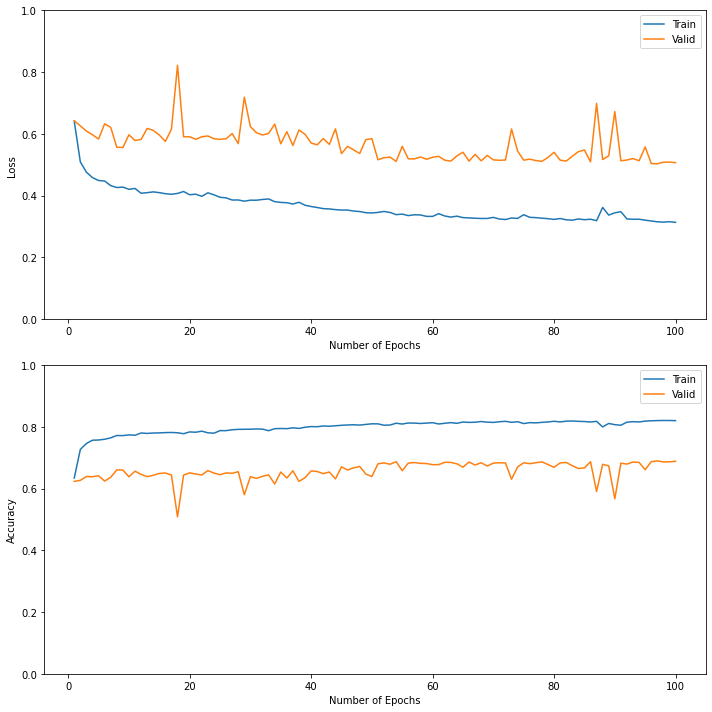

In [50]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.6825    0.9239    0.7851      6061
         1.0     0.8825    0.5708    0.6932      6069

    accuracy                         0.7472     12130
   macro avg     0.7825    0.7474    0.7391     12130
weighted avg     0.7826    0.7472    0.7391     12130



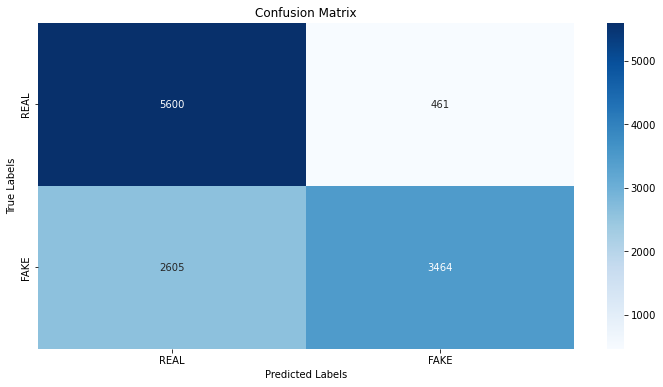

In [51]:
best_model = model_ft
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

### Bidirectional LSTM
---

#### Word Embeddings

In [52]:
text_field.build_vocab(training, min_freq=2)

#for reproducibility
seed_everything()

# LSTM
embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1

# initialize model and train
model = B_LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.4267, Validation Loss: 0.4947, Train Acc: 0.8019, Validation Acc: 0.7749
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.2896, Validation Loss: 0.5546, Train Acc: 0.8815, Validation Acc: 0.7677


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.2345, Validation Loss: 0.2991, Train Acc: 0.9078, Validation Acc: 0.8785
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.2161, Validation Loss: 0.2669, Train Acc: 0.9163, Validation Acc: 0.8855
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.2065, Validation Loss: 0.3087, Train Acc: 0.9204, Validation Acc: 0.8768


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.1909, Validation Loss: 0.2917, Train Acc: 0.9245, Validation Acc: 0.8752


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.1869, Validation Loss: 0.7992, Train Acc: 0.9282, Validation Acc: 0.7307


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.1972, Validation Loss: 0.2506, Train Acc: 0.9233, Validation Acc: 0.8950
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.1837, Validation Loss: 0.3210, Train Acc: 0.9290, Validation Acc: 0.8820


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.1860, Validation Loss: 0.4011, Train Acc: 0.9281, Validation Acc: 0.8413


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.1739, Validation Loss: 0.2848, Train Acc: 0.9338, Validation Acc: 0.8968


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.1916, Validation Loss: 0.4535, Train Acc: 0.9249, Validation Acc: 0.7823


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.1828, Validation Loss: 0.3610, Train Acc: 0.9299, Validation Acc: 0.8506


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.1721, Validation Loss: 0.3672, Train Acc: 0.9342, Validation Acc: 0.8441


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.1817, Validation Loss: 0.5782, Train Acc: 0.9295, Validation Acc: 0.7182


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.1795, Validation Loss: 0.2716, Train Acc: 0.9274, Validation Acc: 0.8957


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.1743, Validation Loss: 1.3747, Train Acc: 0.9331, Validation Acc: 0.6417


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.1741, Validation Loss: 0.2552, Train Acc: 0.9346, Validation Acc: 0.9031


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.1599, Validation Loss: 0.2126, Train Acc: 0.9386, Validation Acc: 0.9134
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.1574, Validation Loss: 0.2878, Train Acc: 0.9391, Validation Acc: 0.8976


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.1548, Validation Loss: 0.2529, Train Acc: 0.9408, Validation Acc: 0.9096


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.1464, Validation Loss: 0.2642, Train Acc: 0.9444, Validation Acc: 0.8854


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.1486, Validation Loss: 0.2827, Train Acc: 0.9436, Validation Acc: 0.8843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.1447, Validation Loss: 0.2056, Train Acc: 0.9479, Validation Acc: 0.9213
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.1349, Validation Loss: 0.2177, Train Acc: 0.9506, Validation Acc: 0.9150


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.1327, Validation Loss: 0.2093, Train Acc: 0.9499, Validation Acc: 0.9177


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.1346, Validation Loss: 0.2245, Train Acc: 0.9500, Validation Acc: 0.9075


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.1297, Validation Loss: 0.3294, Train Acc: 0.9511, Validation Acc: 0.9074


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.1281, Validation Loss: 0.2027, Train Acc: 0.9516, Validation Acc: 0.9219
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.1308, Validation Loss: 0.2566, Train Acc: 0.9495, Validation Acc: 0.9001


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.1276, Validation Loss: 0.3498, Train Acc: 0.9534, Validation Acc: 0.8822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.1291, Validation Loss: 0.3020, Train Acc: 0.9536, Validation Acc: 0.9059


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.1257, Validation Loss: 0.2445, Train Acc: 0.9511, Validation Acc: 0.9098


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.1353, Validation Loss: 0.2748, Train Acc: 0.9504, Validation Acc: 0.8796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.1400, Validation Loss: 0.2101, Train Acc: 0.9488, Validation Acc: 0.9164


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.1167, Validation Loss: 0.2562, Train Acc: 0.9577, Validation Acc: 0.9095


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.1121, Validation Loss: 0.2600, Train Acc: 0.9586, Validation Acc: 0.8938


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.1116, Validation Loss: 0.2882, Train Acc: 0.9593, Validation Acc: 0.9087


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.1094, Validation Loss: 0.2384, Train Acc: 0.9600, Validation Acc: 0.9180


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.1033, Validation Loss: 0.2222, Train Acc: 0.9623, Validation Acc: 0.9219


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.1033, Validation Loss: 0.2052, Train Acc: 0.9611, Validation Acc: 0.9254


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.0948, Validation Loss: 0.3321, Train Acc: 0.9657, Validation Acc: 0.8824


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.1029, Validation Loss: 0.1950, Train Acc: 0.9622, Validation Acc: 0.9235
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.1009, Validation Loss: 0.2263, Train Acc: 0.9629, Validation Acc: 0.9175


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.0957, Validation Loss: 0.2394, Train Acc: 0.9657, Validation Acc: 0.9194


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.0927, Validation Loss: 0.2262, Train Acc: 0.9661, Validation Acc: 0.9250


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.0958, Validation Loss: 0.2067, Train Acc: 0.9664, Validation Acc: 0.9213


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.1008, Validation Loss: 0.2166, Train Acc: 0.9635, Validation Acc: 0.9143


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.1042, Validation Loss: 0.3034, Train Acc: 0.9642, Validation Acc: 0.8927


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.1001, Validation Loss: 0.3298, Train Acc: 0.9642, Validation Acc: 0.9015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.0958, Validation Loss: 1.6804, Train Acc: 0.9661, Validation Acc: 0.5606


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.1161, Validation Loss: 0.2226, Train Acc: 0.9593, Validation Acc: 0.9124


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.1006, Validation Loss: 0.2324, Train Acc: 0.9628, Validation Acc: 0.9142


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.0965, Validation Loss: 0.2548, Train Acc: 0.9654, Validation Acc: 0.9108


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.0895, Validation Loss: 0.1963, Train Acc: 0.9670, Validation Acc: 0.9291


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.0843, Validation Loss: 0.2024, Train Acc: 0.9710, Validation Acc: 0.9275


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.0831, Validation Loss: 0.2202, Train Acc: 0.9704, Validation Acc: 0.9159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.0825, Validation Loss: 0.1863, Train Acc: 0.9708, Validation Acc: 0.9312
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.0819, Validation Loss: 0.2568, Train Acc: 0.9717, Validation Acc: 0.9208


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.0863, Validation Loss: 0.1982, Train Acc: 0.9686, Validation Acc: 0.9242


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.0849, Validation Loss: 0.1950, Train Acc: 0.9699, Validation Acc: 0.9287


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.0799, Validation Loss: 0.2288, Train Acc: 0.9730, Validation Acc: 0.9248


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.0762, Validation Loss: 0.1944, Train Acc: 0.9728, Validation Acc: 0.9303


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.0749, Validation Loss: 0.1956, Train Acc: 0.9741, Validation Acc: 0.9326


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.0887, Validation Loss: 0.1790, Train Acc: 0.9693, Validation Acc: 0.9296
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.0789, Validation Loss: 0.2108, Train Acc: 0.9717, Validation Acc: 0.9246


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.0798, Validation Loss: 0.1825, Train Acc: 0.9718, Validation Acc: 0.9321


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.1050, Validation Loss: 2.3945, Train Acc: 0.9682, Validation Acc: 0.5075


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.1050, Validation Loss: 1.3019, Train Acc: 0.9629, Validation Acc: 0.5542


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.1283, Validation Loss: 0.2820, Train Acc: 0.9526, Validation Acc: 0.9077


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.0995, Validation Loss: 0.1937, Train Acc: 0.9648, Validation Acc: 0.9217


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.1009, Validation Loss: 0.2808, Train Acc: 0.9648, Validation Acc: 0.9110


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.0950, Validation Loss: 0.2283, Train Acc: 0.9668, Validation Acc: 0.9217


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.0839, Validation Loss: 0.2123, Train Acc: 0.9708, Validation Acc: 0.9238


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.0834, Validation Loss: 0.2643, Train Acc: 0.9729, Validation Acc: 0.9183


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.0756, Validation Loss: 0.2276, Train Acc: 0.9743, Validation Acc: 0.9283


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.0728, Validation Loss: 0.2289, Train Acc: 0.9748, Validation Acc: 0.9154


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.0769, Validation Loss: 0.2083, Train Acc: 0.9736, Validation Acc: 0.9257


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.0689, Validation Loss: 0.2290, Train Acc: 0.9774, Validation Acc: 0.9182


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.0692, Validation Loss: 0.2370, Train Acc: 0.9769, Validation Acc: 0.9268


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.0677, Validation Loss: 0.2168, Train Acc: 0.9766, Validation Acc: 0.9264


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.0694, Validation Loss: 0.2908, Train Acc: 0.9766, Validation Acc: 0.8955


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.0674, Validation Loss: 0.3719, Train Acc: 0.9782, Validation Acc: 0.8543


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.0723, Validation Loss: 0.2055, Train Acc: 0.9766, Validation Acc: 0.9343


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.0660, Validation Loss: 0.2172, Train Acc: 0.9768, Validation Acc: 0.9273


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.0624, Validation Loss: 0.2776, Train Acc: 0.9796, Validation Acc: 0.9118


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.0701, Validation Loss: 0.2002, Train Acc: 0.9763, Validation Acc: 0.9275


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.0998, Validation Loss: 0.3773, Train Acc: 0.9716, Validation Acc: 0.8828


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.0819, Validation Loss: 0.1963, Train Acc: 0.9745, Validation Acc: 0.9271


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.0696, Validation Loss: 0.1893, Train Acc: 0.9759, Validation Acc: 0.9310


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.0648, Validation Loss: 0.1829, Train Acc: 0.9775, Validation Acc: 0.9327


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.0532, Validation Loss: 0.1918, Train Acc: 0.9829, Validation Acc: 0.9317


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.0603, Validation Loss: 0.1841, Train Acc: 0.9803, Validation Acc: 0.9259


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.0608, Validation Loss: 0.2521, Train Acc: 0.9802, Validation Acc: 0.9101


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.0772, Validation Loss: 0.2498, Train Acc: 0.9752, Validation Acc: 0.9055


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.0718, Validation Loss: 0.1871, Train Acc: 0.9745, Validation Acc: 0.9300


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.0590, Validation Loss: 0.2844, Train Acc: 0.9812, Validation Acc: 0.9040


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.0541, Validation Loss: 0.2487, Train Acc: 0.9831, Validation Acc: 0.9206


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.0553, Validation Loss: 0.1978, Train Acc: 0.9827, Validation Acc: 0.9296


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.0581, Validation Loss: 0.2136, Train Acc: 0.9821, Validation Acc: 0.9180
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


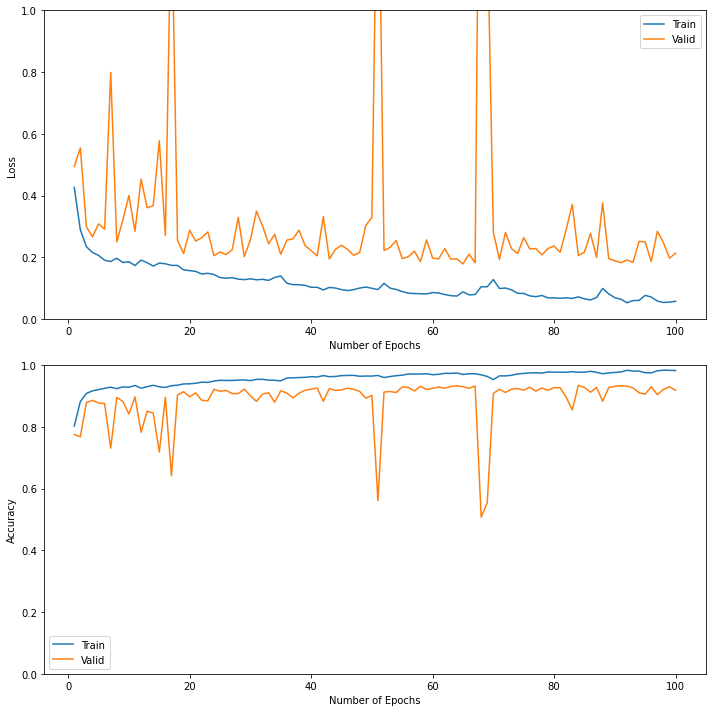

In [53]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9105    0.9429    0.9264      6061
         1.0     0.9409    0.9074    0.9238      6069

    accuracy                         0.9251     12130
   macro avg     0.9257    0.9252    0.9251     12130
weighted avg     0.9257    0.9251    0.9251     12130



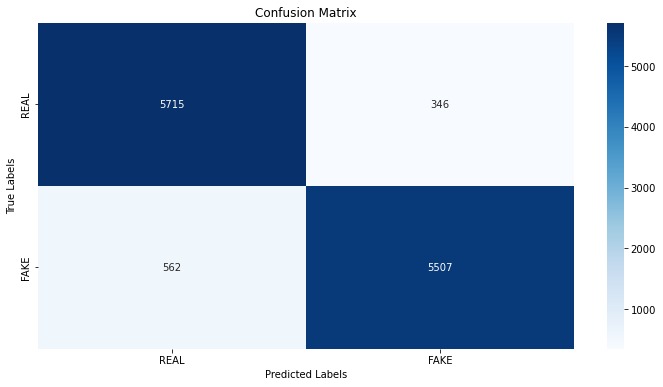

In [54]:
best_model = B_LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

#### Pretrained Word Embeddings: GloVe

In [55]:
text_field.build_vocab(training, min_freq=2, vectors = vocab.Vectors('data/glove.6B.300d.txt'))

embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1

pretrained_embeddings = text_field.vocab.vectors
model_glove = B_LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model_glove.embedding.weight.data = pretrained_embeddings.cuda()
model_glove.embedding.weight.requires_grad = False
optimizer = optim.Adam(model_glove.parameters(), lr=0.001, weight_decay=1e-3)

train(model=model_glove, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.4687, Validation Loss: 0.9536, Train Acc: 0.7824, Validation Acc: 0.5163
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.3422, Validation Loss: 0.4904, Train Acc: 0.8566, Validation Acc: 0.7839
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.2983, Validation Loss: 0.4324, Train Acc: 0.8743, Validation Acc: 0.8281
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.2595, Validation Loss: 0.3008, Train Acc: 0.8943, Validation Acc: 0.8690
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.2368, Validation Loss: 0.3196, Train Acc: 0.9037, Validation Acc: 0.8696


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.2250, Validation Loss: 0.2969, Train Acc: 0.9075, Validation Acc: 0.8754
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.2089, Validation Loss: 0.2718, Train Acc: 0.9156, Validation Acc: 0.8838
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.1982, Validation Loss: 0.4137, Train Acc: 0.9202, Validation Acc: 0.7899


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.1885, Validation Loss: 0.3308, Train Acc: 0.9248, Validation Acc: 0.8603


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.1814, Validation Loss: 0.4411, Train Acc: 0.9262, Validation Acc: 0.8481


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.1936, Validation Loss: 0.3355, Train Acc: 0.9235, Validation Acc: 0.8495


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.1700, Validation Loss: 0.2853, Train Acc: 0.9327, Validation Acc: 0.8769


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.1739, Validation Loss: 0.2336, Train Acc: 0.9311, Validation Acc: 0.9045
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.1641, Validation Loss: 0.2443, Train Acc: 0.9364, Validation Acc: 0.9003


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.1578, Validation Loss: 0.2475, Train Acc: 0.9384, Validation Acc: 0.9029


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.1537, Validation Loss: 0.3169, Train Acc: 0.9390, Validation Acc: 0.8806


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.1585, Validation Loss: 0.2831, Train Acc: 0.9378, Validation Acc: 0.8952


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.1535, Validation Loss: 0.2249, Train Acc: 0.9404, Validation Acc: 0.9055
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.1506, Validation Loss: 0.3197, Train Acc: 0.9409, Validation Acc: 0.8776


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.1480, Validation Loss: 0.4101, Train Acc: 0.9405, Validation Acc: 0.8469


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.1462, Validation Loss: 0.2983, Train Acc: 0.9417, Validation Acc: 0.8685


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.1379, Validation Loss: 0.2890, Train Acc: 0.9459, Validation Acc: 0.8861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.1353, Validation Loss: 0.2256, Train Acc: 0.9488, Validation Acc: 0.9113


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.1355, Validation Loss: 0.3774, Train Acc: 0.9478, Validation Acc: 0.8629


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.1453, Validation Loss: 0.3133, Train Acc: 0.9453, Validation Acc: 0.8746


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.1414, Validation Loss: 0.3807, Train Acc: 0.9436, Validation Acc: 0.8509


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.1381, Validation Loss: 0.2513, Train Acc: 0.9445, Validation Acc: 0.9020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.1250, Validation Loss: 0.2445, Train Acc: 0.9518, Validation Acc: 0.9066


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.1220, Validation Loss: 0.2959, Train Acc: 0.9530, Validation Acc: 0.8955


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.1203, Validation Loss: 0.3408, Train Acc: 0.9542, Validation Acc: 0.8720


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.1226, Validation Loss: 0.3239, Train Acc: 0.9530, Validation Acc: 0.8736


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.1218, Validation Loss: 0.2677, Train Acc: 0.9530, Validation Acc: 0.8983


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.1233, Validation Loss: 0.3360, Train Acc: 0.9519, Validation Acc: 0.8734


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.1217, Validation Loss: 0.2622, Train Acc: 0.9537, Validation Acc: 0.9031


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.1122, Validation Loss: 0.2152, Train Acc: 0.9556, Validation Acc: 0.9159
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.1094, Validation Loss: 0.3241, Train Acc: 0.9592, Validation Acc: 0.8833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.1065, Validation Loss: 0.2299, Train Acc: 0.9590, Validation Acc: 0.9136


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.1022, Validation Loss: 0.4893, Train Acc: 0.9610, Validation Acc: 0.8462


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.1138, Validation Loss: 0.2712, Train Acc: 0.9564, Validation Acc: 0.8987


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.1071, Validation Loss: 0.4219, Train Acc: 0.9599, Validation Acc: 0.8521


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.1097, Validation Loss: 0.4136, Train Acc: 0.9581, Validation Acc: 0.8497


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.1147, Validation Loss: 0.3376, Train Acc: 0.9556, Validation Acc: 0.8773


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.1058, Validation Loss: 0.2257, Train Acc: 0.9596, Validation Acc: 0.9091


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.1023, Validation Loss: 0.2730, Train Acc: 0.9597, Validation Acc: 0.9020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.0980, Validation Loss: 0.3307, Train Acc: 0.9626, Validation Acc: 0.8902


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.0995, Validation Loss: 0.3734, Train Acc: 0.9615, Validation Acc: 0.8761


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.0995, Validation Loss: 0.2949, Train Acc: 0.9626, Validation Acc: 0.9003


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.0994, Validation Loss: 0.3632, Train Acc: 0.9631, Validation Acc: 0.8778


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.1037, Validation Loss: 0.3301, Train Acc: 0.9612, Validation Acc: 0.8743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.0964, Validation Loss: 0.2878, Train Acc: 0.9631, Validation Acc: 0.9010


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.0967, Validation Loss: 0.3306, Train Acc: 0.9640, Validation Acc: 0.8864


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.0991, Validation Loss: 0.2092, Train Acc: 0.9641, Validation Acc: 0.9189
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.0922, Validation Loss: 0.2158, Train Acc: 0.9657, Validation Acc: 0.9191


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.0874, Validation Loss: 0.3414, Train Acc: 0.9675, Validation Acc: 0.8875


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.0874, Validation Loss: 0.3154, Train Acc: 0.9671, Validation Acc: 0.8906


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.0874, Validation Loss: 0.2725, Train Acc: 0.9684, Validation Acc: 0.8950


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.0947, Validation Loss: 0.3623, Train Acc: 0.9635, Validation Acc: 0.8831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.0916, Validation Loss: 0.2254, Train Acc: 0.9662, Validation Acc: 0.9203


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.0778, Validation Loss: 0.3742, Train Acc: 0.9712, Validation Acc: 0.8836


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.0830, Validation Loss: 0.4194, Train Acc: 0.9700, Validation Acc: 0.8660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.0795, Validation Loss: 0.3611, Train Acc: 0.9710, Validation Acc: 0.8813


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.0811, Validation Loss: 0.2326, Train Acc: 0.9704, Validation Acc: 0.9156


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.0795, Validation Loss: 0.2649, Train Acc: 0.9718, Validation Acc: 0.8987


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.0799, Validation Loss: 0.3674, Train Acc: 0.9693, Validation Acc: 0.8894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.0772, Validation Loss: 0.2741, Train Acc: 0.9723, Validation Acc: 0.9055


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.0749, Validation Loss: 0.3764, Train Acc: 0.9727, Validation Acc: 0.8839


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.0705, Validation Loss: 0.3466, Train Acc: 0.9737, Validation Acc: 0.8873


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.0710, Validation Loss: 0.2653, Train Acc: 0.9755, Validation Acc: 0.9103


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.0692, Validation Loss: 0.2926, Train Acc: 0.9760, Validation Acc: 0.9057


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.0712, Validation Loss: 0.2195, Train Acc: 0.9751, Validation Acc: 0.9203


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.0723, Validation Loss: 0.2875, Train Acc: 0.9739, Validation Acc: 0.8966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.0752, Validation Loss: 0.3115, Train Acc: 0.9728, Validation Acc: 0.8994


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.0669, Validation Loss: 0.2873, Train Acc: 0.9758, Validation Acc: 0.9078


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.0680, Validation Loss: 0.2858, Train Acc: 0.9760, Validation Acc: 0.9124


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.0711, Validation Loss: 0.2601, Train Acc: 0.9751, Validation Acc: 0.9043


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.0679, Validation Loss: 0.2181, Train Acc: 0.9769, Validation Acc: 0.9229


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.0684, Validation Loss: 0.3456, Train Acc: 0.9763, Validation Acc: 0.8894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.0709, Validation Loss: 0.3512, Train Acc: 0.9753, Validation Acc: 0.8894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.0652, Validation Loss: 0.2747, Train Acc: 0.9774, Validation Acc: 0.9075


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.0618, Validation Loss: 0.4109, Train Acc: 0.9789, Validation Acc: 0.8713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.0631, Validation Loss: 0.3635, Train Acc: 0.9765, Validation Acc: 0.8926


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.0610, Validation Loss: 0.2823, Train Acc: 0.9796, Validation Acc: 0.9019


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.0663, Validation Loss: 0.2791, Train Acc: 0.9767, Validation Acc: 0.9027


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.0575, Validation Loss: 0.2906, Train Acc: 0.9802, Validation Acc: 0.9106


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.0684, Validation Loss: 0.3226, Train Acc: 0.9774, Validation Acc: 0.8883


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.0622, Validation Loss: 0.3780, Train Acc: 0.9778, Validation Acc: 0.8931


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.0637, Validation Loss: 0.2278, Train Acc: 0.9780, Validation Acc: 0.9212


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.0672, Validation Loss: 0.3789, Train Acc: 0.9756, Validation Acc: 0.8820


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.0628, Validation Loss: 0.2327, Train Acc: 0.9774, Validation Acc: 0.9206


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.0589, Validation Loss: 0.2405, Train Acc: 0.9791, Validation Acc: 0.9201


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.0558, Validation Loss: 0.2852, Train Acc: 0.9812, Validation Acc: 0.9040


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.0589, Validation Loss: 0.2925, Train Acc: 0.9799, Validation Acc: 0.9001


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.0588, Validation Loss: 0.3299, Train Acc: 0.9799, Validation Acc: 0.9027


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.0517, Validation Loss: 0.3201, Train Acc: 0.9827, Validation Acc: 0.9055


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.0543, Validation Loss: 0.2762, Train Acc: 0.9824, Validation Acc: 0.9001


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.0564, Validation Loss: 0.2933, Train Acc: 0.9811, Validation Acc: 0.9145


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.0552, Validation Loss: 0.2603, Train Acc: 0.9819, Validation Acc: 0.9192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.0551, Validation Loss: 0.2629, Train Acc: 0.9818, Validation Acc: 0.9119


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.0564, Validation Loss: 0.3090, Train Acc: 0.9799, Validation Acc: 0.9045


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.0504, Validation Loss: 0.2767, Train Acc: 0.9833, Validation Acc: 0.9145
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


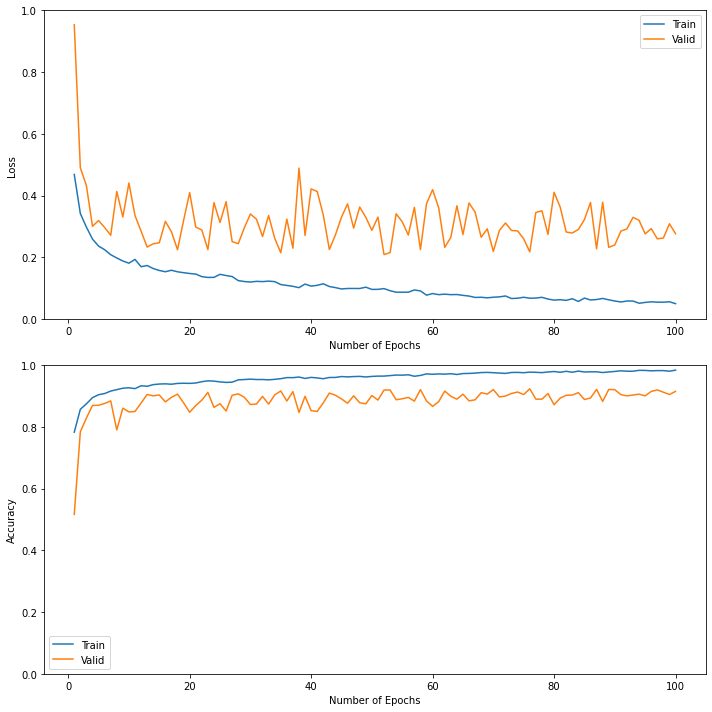

In [56]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9577    0.8784    0.9164      6061
         1.0     0.8878    0.9613    0.9231      6069

    accuracy                         0.9199     12130
   macro avg     0.9228    0.9198    0.9197     12130
weighted avg     0.9228    0.9199    0.9197     12130



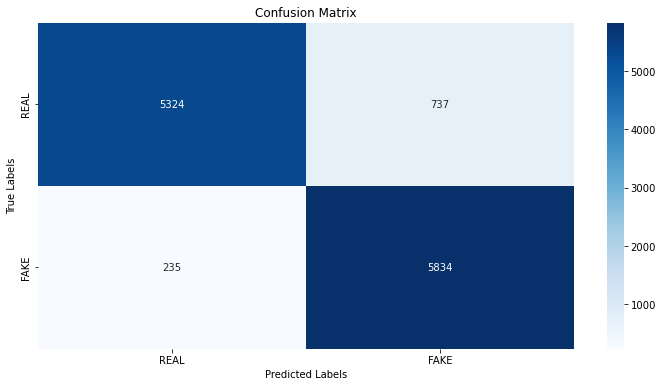

In [57]:
best_model = model_glove
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

#### Pretrained Word Embeddings: FastText

In [58]:
text_field.build_vocab(training, min_freq=2, vectors = vocab.Vectors('data/wiki-news-300d-1M.vec'))

embedding_dim = 300
input_dim = len(text_field.vocab)
hidden_dim =  128
output_dim = 1

pretrained_embeddings = text_field.vocab.vectors
model_ft = B_LSTM(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
model_ft.embedding.weight.data = pretrained_embeddings.cuda()
model_ft.embedding.weight.requires_grad = False
optimizer = optim.Adam(model_ft.parameters() , lr=0.001, weight_decay=1e-3)

train(model=model_ft, optimizer=optimizer, num_epochs=100, file_path = destination_path)

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/100], Step [354/35400], Train Loss: 0.6079, Validation Loss: 0.6599, Train Acc: 0.6903, Validation Acc: 0.5741
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/100], Step [708/35400], Train Loss: 0.4160, Validation Loss: 0.6947, Train Acc: 0.8221, Validation Acc: 0.5342


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/100], Step [1062/35400], Train Loss: 0.4188, Validation Loss: 0.5661, Train Acc: 0.8114, Validation Acc: 0.7194
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/100], Step [1416/35400], Train Loss: 0.3567, Validation Loss: 0.3533, Train Acc: 0.8429, Validation Acc: 0.8485
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/100], Step [1770/35400], Train Loss: 0.3046, Validation Loss: 0.3644, Train Acc: 0.8747, Validation Acc: 0.8441


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/100], Step [2124/35400], Train Loss: 0.2939, Validation Loss: 0.3641, Train Acc: 0.8805, Validation Acc: 0.8355


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/100], Step [2478/35400], Train Loss: 0.2998, Validation Loss: 0.5051, Train Acc: 0.8735, Validation Acc: 0.7767


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/100], Step [2832/35400], Train Loss: 0.2758, Validation Loss: 0.3851, Train Acc: 0.8904, Validation Acc: 0.8383


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/100], Step [3186/35400], Train Loss: 0.2643, Validation Loss: 1.1447, Train Acc: 0.8905, Validation Acc: 0.5077


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/100], Step [3540/35400], Train Loss: 0.3560, Validation Loss: 0.4934, Train Acc: 0.8479, Validation Acc: 0.7870


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/100], Step [3894/35400], Train Loss: 0.2964, Validation Loss: 0.3672, Train Acc: 0.8772, Validation Acc: 0.8316


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/100], Step [4248/35400], Train Loss: 0.2589, Validation Loss: 0.4290, Train Acc: 0.8963, Validation Acc: 0.7971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/100], Step [4602/35400], Train Loss: 0.2892, Validation Loss: 0.5504, Train Acc: 0.8801, Validation Acc: 0.7203


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/100], Step [4956/35400], Train Loss: 0.3251, Validation Loss: 0.7821, Train Acc: 0.8680, Validation Acc: 0.5116


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/100], Step [5310/35400], Train Loss: 0.2995, Validation Loss: 0.3626, Train Acc: 0.8710, Validation Acc: 0.8525


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/100], Step [5664/35400], Train Loss: 0.2963, Validation Loss: 0.5630, Train Acc: 0.8755, Validation Acc: 0.7072


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/100], Step [6018/35400], Train Loss: 0.3038, Validation Loss: 0.3151, Train Acc: 0.8699, Validation Acc: 0.8696
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/100], Step [6372/35400], Train Loss: 0.2570, Validation Loss: 0.3038, Train Acc: 0.8964, Validation Acc: 0.8734
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/100], Step [6726/35400], Train Loss: 0.2543, Validation Loss: 0.2760, Train Acc: 0.8980, Validation Acc: 0.8822
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/100], Step [7080/35400], Train Loss: 0.2479, Validation Loss: 0.2769, Train Acc: 0.8997, Validation Acc: 0.8780


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/100], Step [7434/35400], Train Loss: 0.2427, Validation Loss: 0.3363, Train Acc: 0.8998, Validation Acc: 0.8639


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/100], Step [7788/35400], Train Loss: 0.2526, Validation Loss: 0.4265, Train Acc: 0.8986, Validation Acc: 0.8209


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/100], Step [8142/35400], Train Loss: 0.2510, Validation Loss: 0.3436, Train Acc: 0.8933, Validation Acc: 0.8643


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/100], Step [8496/35400], Train Loss: 0.2413, Validation Loss: 0.2659, Train Acc: 0.9029, Validation Acc: 0.8899
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/100], Step [8850/35400], Train Loss: 0.2616, Validation Loss: 0.5244, Train Acc: 0.8913, Validation Acc: 0.7505


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/100], Step [9204/35400], Train Loss: 0.2656, Validation Loss: 0.4678, Train Acc: 0.8899, Validation Acc: 0.8155


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/100], Step [9558/35400], Train Loss: 0.2488, Validation Loss: 0.4001, Train Acc: 0.8967, Validation Acc: 0.8462


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/100], Step [9912/35400], Train Loss: 0.2373, Validation Loss: 0.2435, Train Acc: 0.8994, Validation Acc: 0.8924
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/100], Step [10266/35400], Train Loss: 0.2236, Validation Loss: 0.3033, Train Acc: 0.9064, Validation Acc: 0.8727


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/100], Step [10620/35400], Train Loss: 0.2264, Validation Loss: 0.2743, Train Acc: 0.9038, Validation Acc: 0.8843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/100], Step [10974/35400], Train Loss: 0.2255, Validation Loss: 0.2818, Train Acc: 0.9041, Validation Acc: 0.8750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/100], Step [11328/35400], Train Loss: 0.2274, Validation Loss: 0.3334, Train Acc: 0.9041, Validation Acc: 0.8699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/100], Step [11682/35400], Train Loss: 0.2257, Validation Loss: 0.2755, Train Acc: 0.9063, Validation Acc: 0.8861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/100], Step [12036/35400], Train Loss: 0.2200, Validation Loss: 0.2428, Train Acc: 0.9085, Validation Acc: 0.8922
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/100], Step [12390/35400], Train Loss: 0.2175, Validation Loss: 0.3154, Train Acc: 0.9118, Validation Acc: 0.8569


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/100], Step [12744/35400], Train Loss: 0.2194, Validation Loss: 0.2389, Train Acc: 0.9092, Validation Acc: 0.8980
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/100], Step [13098/35400], Train Loss: 0.2160, Validation Loss: 0.3109, Train Acc: 0.9120, Validation Acc: 0.8615


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/100], Step [13452/35400], Train Loss: 0.2290, Validation Loss: 0.2733, Train Acc: 0.9055, Validation Acc: 0.8836


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/100], Step [13806/35400], Train Loss: 0.2153, Validation Loss: 0.3404, Train Acc: 0.9125, Validation Acc: 0.8662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/100], Step [14160/35400], Train Loss: 0.2114, Validation Loss: 0.2730, Train Acc: 0.9122, Validation Acc: 0.8878


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/100], Step [14514/35400], Train Loss: 0.2227, Validation Loss: 0.3837, Train Acc: 0.9112, Validation Acc: 0.8416


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/100], Step [14868/35400], Train Loss: 0.2183, Validation Loss: 0.2954, Train Acc: 0.9117, Validation Acc: 0.8808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/100], Step [15222/35400], Train Loss: 0.2135, Validation Loss: 1.2661, Train Acc: 0.9132, Validation Acc: 0.5934


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/100], Step [15576/35400], Train Loss: 0.2334, Validation Loss: 0.5320, Train Acc: 0.9077, Validation Acc: 0.8023


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/100], Step [15930/35400], Train Loss: 0.2357, Validation Loss: 0.3010, Train Acc: 0.9031, Validation Acc: 0.8725


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/100], Step [16284/35400], Train Loss: 0.2205, Validation Loss: 0.2810, Train Acc: 0.9062, Validation Acc: 0.8792


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/100], Step [16638/35400], Train Loss: 0.2081, Validation Loss: 0.2492, Train Acc: 0.9127, Validation Acc: 0.8892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/100], Step [16992/35400], Train Loss: 0.1988, Validation Loss: 0.2432, Train Acc: 0.9197, Validation Acc: 0.8943


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/100], Step [17346/35400], Train Loss: 0.1999, Validation Loss: 0.2546, Train Acc: 0.9180, Validation Acc: 0.8876


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/100], Step [17700/35400], Train Loss: 0.1997, Validation Loss: 0.2576, Train Acc: 0.9185, Validation Acc: 0.8887


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [51/100], Step [18054/35400], Train Loss: 0.1940, Validation Loss: 0.2907, Train Acc: 0.9215, Validation Acc: 0.8769


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [52/100], Step [18408/35400], Train Loss: 0.1972, Validation Loss: 0.2748, Train Acc: 0.9198, Validation Acc: 0.8806


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [53/100], Step [18762/35400], Train Loss: 0.1906, Validation Loss: 0.2573, Train Acc: 0.9242, Validation Acc: 0.8897


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [54/100], Step [19116/35400], Train Loss: 0.1921, Validation Loss: 0.2352, Train Acc: 0.9224, Validation Acc: 0.9013
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [55/100], Step [19470/35400], Train Loss: 0.1891, Validation Loss: 0.5779, Train Acc: 0.9255, Validation Acc: 0.6931


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [56/100], Step [19824/35400], Train Loss: 0.2070, Validation Loss: 0.2722, Train Acc: 0.9179, Validation Acc: 0.8789


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [57/100], Step [20178/35400], Train Loss: 0.1970, Validation Loss: 0.3845, Train Acc: 0.9192, Validation Acc: 0.8532


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [58/100], Step [20532/35400], Train Loss: 0.1927, Validation Loss: 0.2385, Train Acc: 0.9216, Validation Acc: 0.8962


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [59/100], Step [20886/35400], Train Loss: 0.1832, Validation Loss: 0.2953, Train Acc: 0.9260, Validation Acc: 0.8806


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [60/100], Step [21240/35400], Train Loss: 0.1877, Validation Loss: 0.2610, Train Acc: 0.9256, Validation Acc: 0.8936


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [61/100], Step [21594/35400], Train Loss: 0.1841, Validation Loss: 0.2757, Train Acc: 0.9292, Validation Acc: 0.8804


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [62/100], Step [21948/35400], Train Loss: 0.1857, Validation Loss: 0.2456, Train Acc: 0.9260, Validation Acc: 0.8933


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [63/100], Step [22302/35400], Train Loss: 0.1821, Validation Loss: 0.4012, Train Acc: 0.9270, Validation Acc: 0.8402


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [64/100], Step [22656/35400], Train Loss: 0.1824, Validation Loss: 0.3351, Train Acc: 0.9283, Validation Acc: 0.8557


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [65/100], Step [23010/35400], Train Loss: 0.1770, Validation Loss: 0.2222, Train Acc: 0.9284, Validation Acc: 0.9078
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [66/100], Step [23364/35400], Train Loss: 0.1660, Validation Loss: 0.2266, Train Acc: 0.9340, Validation Acc: 0.8992


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [67/100], Step [23718/35400], Train Loss: 0.1665, Validation Loss: 0.3060, Train Acc: 0.9344, Validation Acc: 0.8810


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [68/100], Step [24072/35400], Train Loss: 0.1668, Validation Loss: 0.2552, Train Acc: 0.9345, Validation Acc: 0.8966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [69/100], Step [24426/35400], Train Loss: 0.1613, Validation Loss: 0.2394, Train Acc: 0.9366, Validation Acc: 0.8978


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [70/100], Step [24780/35400], Train Loss: 0.1620, Validation Loss: 0.2560, Train Acc: 0.9341, Validation Acc: 0.8927


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [71/100], Step [25134/35400], Train Loss: 0.1596, Validation Loss: 0.2009, Train Acc: 0.9351, Validation Acc: 0.9129
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [72/100], Step [25488/35400], Train Loss: 0.1583, Validation Loss: 0.3158, Train Acc: 0.9369, Validation Acc: 0.8622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [73/100], Step [25842/35400], Train Loss: 0.1978, Validation Loss: 1.5690, Train Acc: 0.9286, Validation Acc: 0.5074


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [74/100], Step [26196/35400], Train Loss: 0.1622, Validation Loss: 0.2077, Train Acc: 0.9366, Validation Acc: 0.9117


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [75/100], Step [26550/35400], Train Loss: 0.1562, Validation Loss: 0.2152, Train Acc: 0.9374, Validation Acc: 0.9138


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [76/100], Step [26904/35400], Train Loss: 0.1496, Validation Loss: 0.2457, Train Acc: 0.9416, Validation Acc: 0.8892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [77/100], Step [27258/35400], Train Loss: 0.1488, Validation Loss: 0.2130, Train Acc: 0.9425, Validation Acc: 0.9085


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [78/100], Step [27612/35400], Train Loss: 0.1471, Validation Loss: 0.2123, Train Acc: 0.9422, Validation Acc: 0.9089


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [79/100], Step [27966/35400], Train Loss: 0.1456, Validation Loss: 0.2535, Train Acc: 0.9425, Validation Acc: 0.8940


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [80/100], Step [28320/35400], Train Loss: 0.1407, Validation Loss: 0.7062, Train Acc: 0.9456, Validation Acc: 0.7811


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [81/100], Step [28674/35400], Train Loss: 0.1541, Validation Loss: 0.2755, Train Acc: 0.9376, Validation Acc: 0.8717


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [82/100], Step [29028/35400], Train Loss: 0.1445, Validation Loss: 0.2693, Train Acc: 0.9412, Validation Acc: 0.8933


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [83/100], Step [29382/35400], Train Loss: 0.1390, Validation Loss: 0.2598, Train Acc: 0.9460, Validation Acc: 0.8966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [84/100], Step [29736/35400], Train Loss: 0.1397, Validation Loss: 0.2103, Train Acc: 0.9461, Validation Acc: 0.9124


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [85/100], Step [30090/35400], Train Loss: 0.1303, Validation Loss: 0.2225, Train Acc: 0.9498, Validation Acc: 0.9119


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [86/100], Step [30444/35400], Train Loss: 0.1313, Validation Loss: 0.1973, Train Acc: 0.9485, Validation Acc: 0.9173
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [87/100], Step [30798/35400], Train Loss: 0.1311, Validation Loss: 0.2495, Train Acc: 0.9491, Validation Acc: 0.8878


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [88/100], Step [31152/35400], Train Loss: 0.1343, Validation Loss: 0.2127, Train Acc: 0.9480, Validation Acc: 0.9103


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [89/100], Step [31506/35400], Train Loss: 0.1475, Validation Loss: 0.6729, Train Acc: 0.9423, Validation Acc: 0.6147


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [90/100], Step [31860/35400], Train Loss: 0.1346, Validation Loss: 0.2072, Train Acc: 0.9457, Validation Acc: 0.9150


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [91/100], Step [32214/35400], Train Loss: 0.1248, Validation Loss: 0.1933, Train Acc: 0.9523, Validation Acc: 0.9242
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [92/100], Step [32568/35400], Train Loss: 0.1356, Validation Loss: 0.4199, Train Acc: 0.9489, Validation Acc: 0.8425


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [93/100], Step [32922/35400], Train Loss: 0.1410, Validation Loss: 0.2132, Train Acc: 0.9438, Validation Acc: 0.9077


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [94/100], Step [33276/35400], Train Loss: 0.1295, Validation Loss: 0.5317, Train Acc: 0.9499, Validation Acc: 0.7440


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [95/100], Step [33630/35400], Train Loss: 0.1391, Validation Loss: 0.2074, Train Acc: 0.9459, Validation Acc: 0.9149


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [96/100], Step [33984/35400], Train Loss: 0.1301, Validation Loss: 0.2328, Train Acc: 0.9486, Validation Acc: 0.9033


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [97/100], Step [34338/35400], Train Loss: 0.1241, Validation Loss: 0.2096, Train Acc: 0.9510, Validation Acc: 0.9212


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [98/100], Step [34692/35400], Train Loss: 0.1189, Validation Loss: 0.2304, Train Acc: 0.9543, Validation Acc: 0.9064


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [99/100], Step [35046/35400], Train Loss: 0.1175, Validation Loss: 0.2179, Train Acc: 0.9540, Validation Acc: 0.9112


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [100/100], Step [35400/35400], Train Loss: 0.1182, Validation Loss: 0.1940, Train Acc: 0.9551, Validation Acc: 0.9199
Model saved to ==> C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt
Finished Training!


**Visualizing Loss and Accuracy across Epochs**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/metrics.pt


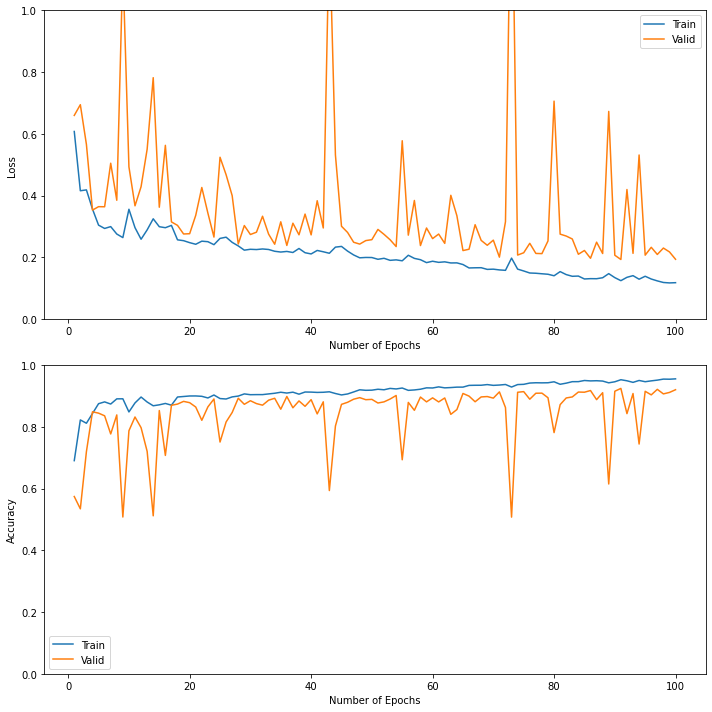

In [59]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list = load_metrics(destination_path + '/metrics.pt')

plot_loss_acc(train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, epoch_list)

**Testing**

Model loaded from <== C:/Users/Malcolm Lau/Desktop/Capstone/models/model.pt
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9197    0.9274    0.9235      6061
         1.0     0.9269    0.9191    0.9230      6069

    accuracy                         0.9232     12130
   macro avg     0.9233    0.9233    0.9232     12130
weighted avg     0.9233    0.9232    0.9232     12130



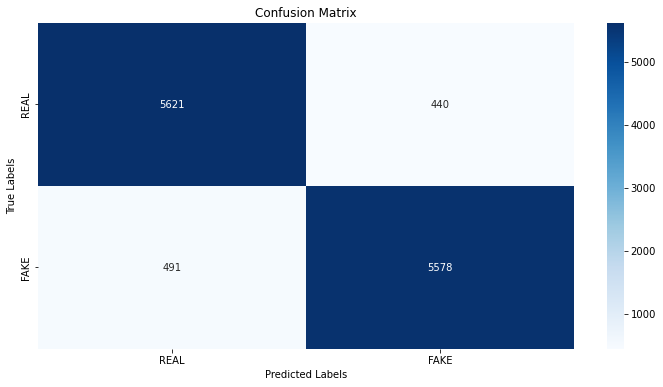

In [60]:
best_model = model_ft
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-3)

load_checkpoint(destination_path + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

### DistilBERT with Linear Output Layer

In [12]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

training_data = data_tokenizer(sentences_train, labels_train)
val_data = data_tokenizer(sentences_val, labels_val)
test_data = data_tokenizer(sentences_test, labels_test)

**DataLoader to batch our samples**

In [13]:
# The DataLoader needs to know our batch size for training, so we specify it here.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            training_data,  # The training samples.
            sampler = RandomSampler(training_data), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_data, # The validation samples.
            sampler = SequentialSampler(val_data), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Test set for evaluation
test_dataloader = DataLoader(
            test_data, # The validation samples.
            sampler = SequentialSampler(test_data), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

**Defining the Model and Optimizer**

In [63]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

    
# Tell pytorch to run this model on the GPU.
model.to(device)
optimizer = AdamW(model.parameters(), lr = 5e-5,
                  eps = 1e-8)

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

**Commence Training Loop**

In [64]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        


        (loss, logits) = model(input_ids=b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                              return_dict=False)

        total_train_loss += loss.item()

        loss.backward()

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            (loss, logits) = model(input_ids= b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                  return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  2,830.    Elapsed: 0:00:15.
  Batch   200  of  2,830.    Elapsed: 0:00:29.
  Batch   300  of  2,830.    Elapsed: 0:00:49.
  Batch   400  of  2,830.    Elapsed: 0:01:08.
  Batch   500  of  2,830.    Elapsed: 0:01:28.
  Batch   600  of  2,830.    Elapsed: 0:01:48.
  Batch   700  of  2,830.    Elapsed: 0:02:07.
  Batch   800  of  2,830.    Elapsed: 0:02:25.
  Batch   900  of  2,830.    Elapsed: 0:02:39.
  Batch 1,000  of  2,830.    Elapsed: 0:02:53.
  Batch 1,100  of  2,830.    Elapsed: 0:03:07.
  Batch 1,200  of  2,830.    Elapsed: 0:03:21.
  Batch 1,300  of  2,830.    Elapsed: 0:03:35.
  Batch 1,400  of  2,830.    Elapsed: 0:03:49.
  Batch 1,500  of  2,830.    Elapsed: 0:04:03.
  Batch 1,600  of  2,830.    Elapsed: 0:04:17.
  Batch 1,700  of  2,830.    Elapsed: 0:04:32.
  Batch 1,800  of  2,830.    Elapsed: 0:04:46.
  Batch 1,900  of  2,830.    Elapsed: 0:05:01.
  Batch 2,000  of  2,830.    Elapsed: 0:05:15.
  Batch 2,100  of

**Visualizing Training Loss**

In [65]:
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.55e-01,0.08,0.97,0:07:13,0:00:32
2,4.34e-02,0.08,0.97,0:07:14,0:00:33
3,1.25e-02,0.12,0.97,0:07:55,0:00:32
4,3.12e-03,0.15,0.97,0:07:49,0:00:45


**Testing**

In [66]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []
total_test_loss = 0
total_test_accuracy = 0

# Predict
progress_bar = tqdm(test_dataloader, leave=False)
for batch in progress_bar:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        loss, logits = model(b_input_ids,
                      attention_mask=b_input_mask, labels= b_labels,return_dict=False)
 
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
              
        total_test_accuracy += flat_accuracy(logits, label_ids)
        
        # Accumulate the validation loss.
        total_test_loss += loss.item()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
# Report the final accuracy for this validation run.
avg_test_accuracy = total_test_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_test_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)
print("  Loss: {0:.2f}".format(avg_test_loss))

  0%|          | 0/1517 [00:00<?, ?it/s]

  Accuracy: 0.97
  Loss: 0.14


              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6061
           1       0.96      0.98      0.97      6069

    accuracy                           0.97     12130
   macro avg       0.97      0.97      0.97     12130
weighted avg       0.97      0.97      0.97     12130



[Text(0, 0.5, 'FAKE'), Text(0, 1.5, 'REAL')]

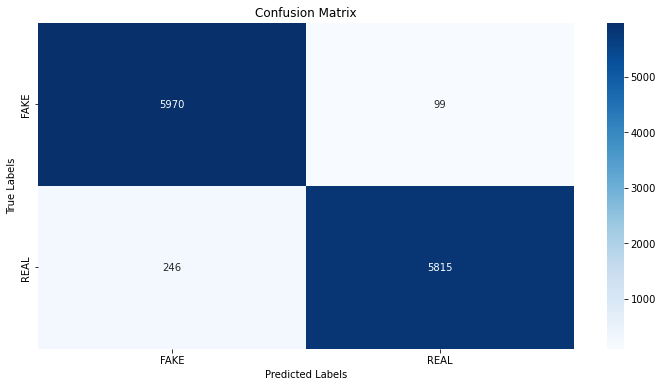

In [67]:
y_pred = []
y_test = []
for i in range(len(true_labels)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    y_pred.extend(pred_labels_i)    
    y_test.extend(true_labels[i])

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

#### Inspecting the Predictions

In [87]:
wrong_preds_idx = []
correct_preds_idx= []

for idx in range(len(y_test)):
    if y_pred[idx] != y_test[idx]:
        wrong_preds_idx.append(idx)
    else:
        correct_preds_idx.append(idx)

print(wrong_preds_idx[:10])
print(correct_preds_idx[:10])

[49, 81, 122, 159, 168, 170, 191, 199, 253, 256]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [88]:
print(labels_test[[49,81,122,159,168, 170, 191,199,253,256]])
print(labels_test[[0,1,2,3,4,5,6,7,8,9]])

[1 1 1 0 0 1 0 0 1 0]
[1 0 1 0 1 1 0 0 1 0]


In [70]:
model.save_pretrained(saved_model_path)

## Results

|     Model    |     Training Loss    |     Validation Loss    |     Test Accuracy    |     Test F1    |
|---|---|---|---|---|
|     GRU/ Embeddings    |     0.254    |     0.509    |     0.756    |     0.747    |
|     GRU/ GloVe    |     0.253    |     0.541    |     0.747    |     0.739    |
|     GRU/ FastText    |     0.307    |     0.517    |     0.745    |     0.736    |
|     B-GRU/ Embeddings    |     0.030    |     0.180    |     0.941    |     0.941    |
|     B-GRU/ GloVe    |     0.036    |     0.317    |     0.915    |     0.915    |
|     B-GRU/ FastText    |     0.091    |     0.282    |     0.926    |     0.926    |
|     LSTM/Embeddings    |     0.252    |     0.511    |     0.758    |     0.750    |
|     LSTM/GloVe    |     0.258    |     0.506    |     0.750    |     0.740    |
|     LSTM/FastText    |     0.314    |     0.507    |     0.747    |     0.739    |
|     B-LSTM/Embeddings    |     0.058    |     0.214    |     0.925    |     0.925    |
|     B-LSTM/GloVe    |     0.050    |     0.2767    |     0.920    |     0.920    |
|     B-LSTM/FastText    |     0.118    |     0.194    |     0.923    |     0.923    |
|     DistilBERT/Linear Layer    |     0.00312    |     0.15    |     0.97    |     0.97    |

From the results, it is evident that the best performing deep learning model and best performing model overall is the **DistilBERT Classifier**.


We can also observe the following:

* The Bidirectional GRU and LSTM have marked performance improvement over the one-directional versions (close to 20% improvement in both accuracy and F1 score). This means that having future information is important in the prediction of fake reviews.

* The performance of models using both GloVe and FastText achieved similar scores.  


* As a whole the pre-trained embeddings do not perform better than the 'vanilla' word embeddings used in the model, a possible reason might be due to the number of OOV words which impeded performance.

### Interpreting DistilBERT Outputs using LIME

To interpret the output of the DistilBERT model, we will be using the **Local interpretable model-agnostic explanations (LIME)** library to create Local Surrogate Model. Local Surrogate Models are interpretable models that are used to explain individual predictions of black box machine learning models.

We will first load the DistilBERT Classifier model that we trained earlier.

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(saved_model_path)
class_names = ['REAL', 'FAKE']

#### Helper Function to Generate Prediction Probabilities

In [16]:
def predictor(texts):
    with torch.no_grad():
        outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits).detach().numpy()
    return probas

#### Correct Classifications

**TRUE POSITIVE** - Correctly predicted Fake reviews

Running....
 The probabilities are [[1.0194418e-05 9.9998975e-01]] for REAL and FAKE respectively
True class: FAKE



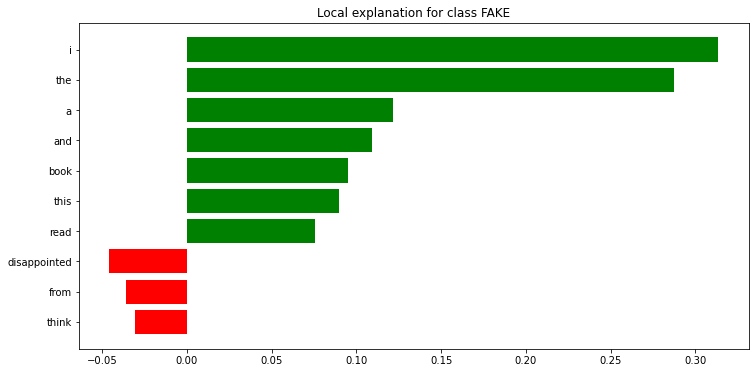

In [18]:
# Test string
text = sentences_test[4]

print('Running....')
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text, predictor, num_features=10, num_samples=1000)
print(f' The probabilities are {predictor(text)} for REAL and FAKE respectively')
print(f'True class: {class_names[labels_test[4]]}')
print()
fig = exp.as_pyplot_figure()

**TRUE NEGATIVE** - Correctly predicted Real reviews 

Running....
 The probabilities are [[9.9997723e-01 2.2806653e-05]] for REAL and FAKE respectively
True class: REAL



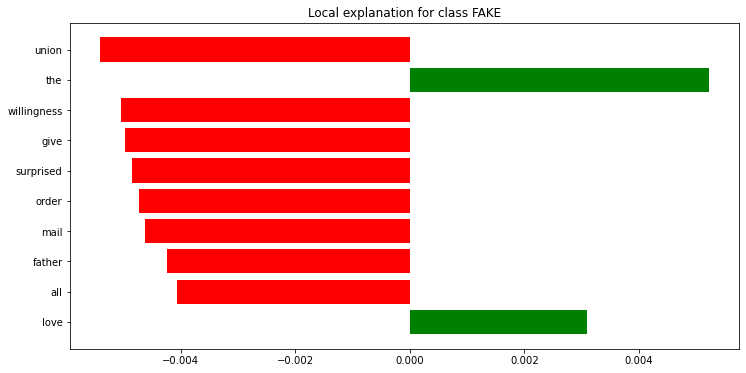

In [19]:
# Test string
text = sentences_test[9]
print('Running....')
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text, predictor, num_features=10, num_samples=1000)
print(f' The probabilities are {predictor(text)} for REAL and FAKE respectively')
print(f'True class: {class_names[labels_test[9]]}')
print()
fig = exp.as_pyplot_figure()

#### Incorrect Classifications


**FALSE NEGATIVE** - Fake review predicted as Real

 The probabilities are [[0.5795719  0.42042816]] for REAL and FAKE respectively
True class: FAKE



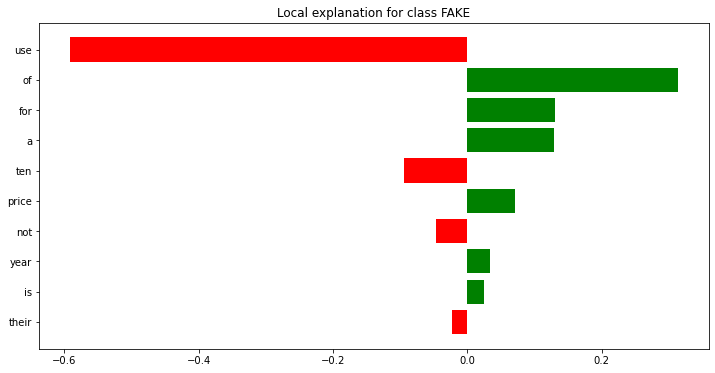

In [29]:
# Test string
text = sentences_test[170]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text, predictor, num_features=10, num_samples=1000)
print(f' The probabilities are {predictor(text)} for REAL and FAKE respectively')
print(f'True class: {class_names[labels_test[170]]}')
print()
fig = exp.as_pyplot_figure()

**FALSE POSITIVE** - Real review predicted as Fake

 The probabilities are [[0.24093935 0.7590607 ]] for REAL and FAKE respectively
True class: REAL



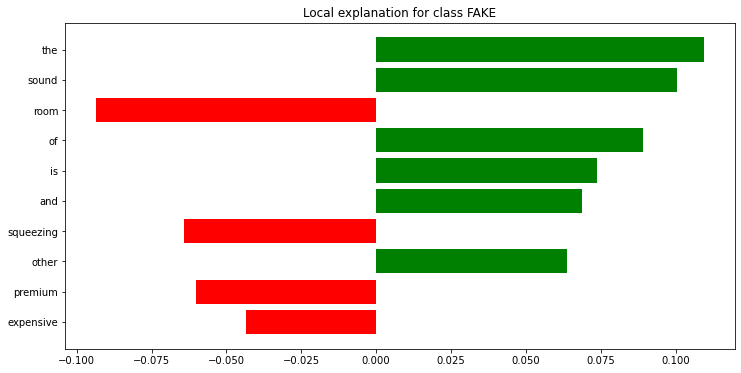

In [28]:
# Test string
text = sentences_test[159]
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text, predictor, num_features=10, num_samples=1000)
print(f' The probabilities are {predictor(text)} for REAL and FAKE respectively')
print(f'True class: {class_names[labels_test[159]]}')
print()
fig = exp.as_pyplot_figure()

### Analysis


From the LIME representations above for a small sample of the test set, we can make the following observation:
* Reviews with adjectives (eg. premium, expensive, surprised, disappointed) are likely to be real reviews.

* Word '**I**' has relatively higher positive weights. This means that fake reviews are likely to be written in the first-person. 

* Word '**the**' is the most commonly used word in the english language, having it being a strong predictor a fake review means that there will be a larger number of reviews being incorrectly classified as fake, which is confirmed to be the case (refer to Confusion Matrix for the DistilBERT Classifier)

# Project Conclusion

| Model | Variants | Accuracy | F1 Score |
|:---:|:---:|:---:|:---:|
| Multinomial NB | CVEC | 0.830 | 0.842 |
| Logistic Regression/ TF-IDF Vectorizer | TVEC | 0.902 | 0.891 |
| DistilBERT Classifier | - | 0.970 | 0.970 |

If immediate deployment is required, **recommend to adopt the DistilBERT model** as it has the highest performance, model training time is also fast (~30 minutes for a mini batch of 2.8k batches for 4 epochs)

If time allows, preferable to use Logistic Regression due to better interpretability, lower complexity and training time 
(< 5 minutes), will likely meet F1 score requirements after further hyperparameter tuning


#### 